In [1]:
from platform import python_version
print(python_version())

3.9.16


In [33]:
%matplotlib inline
#%reset
import sys
import numpy as np
import os
import math
import cv2
import shutil
import time
import random
import matplotlib.image as img
import tensorflow as tf
import itertools
import pandas as pd
import seaborn as sns
from PIL import Image
import dill

from skopt import Optimizer, gp_minimize
from skopt.space import Real, Integer, Categorical
from skopt.utils import use_named_args



# ensure we are training on GPU
# print(tf.__version__)
# print(tf.__file__)
# print(tf.config.list_physical_devices())
#print(tf.config.list_physical_devices('GPU'))

from tensorflow import keras
from keras.callbacks import EarlyStopping
#from IPython.display import Image, display
import matplotlib.pyplot as plt

ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator

# Optionally save/load in serialized session

In [56]:
SAVE_SERIALIZED_SESSION = True
LOAD_SERIALIZED_SESSION = False
SESSION_PATH = "C:\dev\programming_2023\cnn_project\sessions"

session_file = os.path.join(SESSION_PATH, "session_state.pkl")

if SAVE_SERIALIZED_SESSION:
    with open(session_file, "wb") as file:
        dill.dump_session(file)

if LOAD_SERIALIZED_SESSION:
    with open(session_file, "rb") as file:
        dill.load_session(file)


In [3]:
# set random seed to ensure determinism for hyperparameter comparison, without shuffling
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)
tf.config.experimental.enable_op_determinism()

## Base image directory path and other paths

In [4]:
BASE_IMAGE_DIR = "C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages"

CAT_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'Cat')
DOG_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'Dog')
CORRUPTED_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'corrupted')
TRAINED_MODELS_DIR = os.path.join(BASE_IMAGE_DIR, 'models')
SAVE_DIR = r"C:\dev\programming_2023\cnn_project\training_plots"



# Flag to disable running preprocessing functions
run_setup = True

## Set up data directories to cleanse data

Found 12488 images in the cat directory.
Found 12487 images in the dog directory.


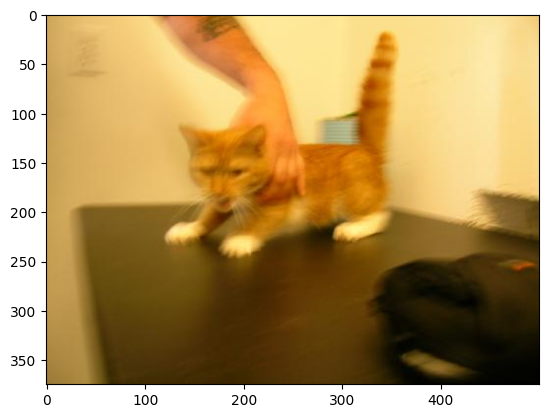

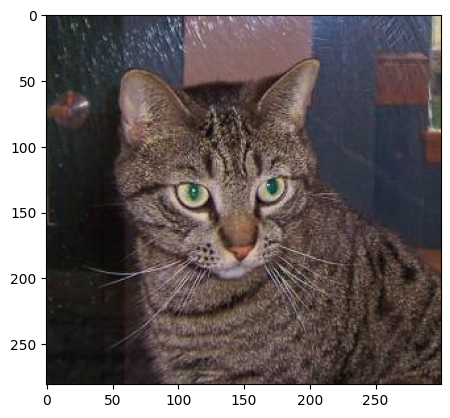

In [5]:
def create_dirs_and_test_loading(
    corrupted_image_dir=CORRUPTED_IMAGE_DIR,
    trained_models_dir=TRAINED_MODELS_DIR,
    cat_image_dir=CAT_IMAGE_DIR,
    dog_image_dir=DOG_IMAGE_DIR
):
    
    if not os.path.exists(corrupted_image_dir):
        print("Creating {}".format(corrupted_image_dir))
        os.makekdirs(corrupted_image_dir)

    if not os.path.exists(trained_models_dir):
        print("Creating {}".format(trained_models_dir))
        os.makekdirs(trained_models_dir)


    print("Found {} images in the cat directory.".format(len(os.listdir(cat_image_dir))))
    print("Found {} images in the dog directory.".format(len(os.listdir(dog_image_dir))))

    # display the first 2 images of the cat directory as a santity check
    first_images = os.listdir(cat_image_dir)[:2]
    for image in first_images:
        test_img_path = "{}/{}".format(cat_image_dir, image)
        test_img =  cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)

        plt.imshow(test_img)
        plt.show()
        
if run_setup: 
    create_dirs_and_test_loading()

## Remove corrupted images

In [7]:
def cleanse_data(
    cat_dir=CAT_IMAGE_DIR,
    dog_dir=DOG_IMAGE_DIR,
    corrupted_image_dir=CORRUPTED_IMAGE_DIR
):
    
    cat_images = os.listdir(cat_dir)
    for image in cat_images:
        test_img_path = "{}/{}".format(cat_dir, image)
        try:
            im = Image.open(test_img_path)
        except:
            print("Found corrupted image: {}. Moving to: {} ".format(test_img_path, corrupted_image_dir))
            corrupted_path = "{}/{}".format(corrupted_image_dir, image)
            os.rename(test_img_path, corrupted_path)
            continue

    dog_images = os.listdir(dog_dir)
    for image in dog_images:
        test_img_path = "{}/{}".format(dog_dir, image)
        try:
            im = Image.open(test_img_path)
        except:
            print("Found corrupted image: {}. Moving to: {} ".format(test_img_path, corrupted_image_dir))
            corrupted_path = "{}/{}".format(corrupted_image_dir, image)
            os.rename(test_img_path, corrupted_path)
            continue
            
if run_setup:
    cleanse_data()

## Parameterized class for image classifier to train and test various hyperparameters

In [65]:
class CatDogImageClassifier():
    def __init__(
        self,
        model_name,
        batch_size,
        activation_function, # currently used in the architecture params
        loss_function,
        epochs,
        layer_configs,
        dropout_rate=None
    ):
        self.model_name=model_name
        self.batch_size=batch_size
        self.activation_function=activation_function
        self.loss_function=loss_function
        self.epochs=epochs
        self.layer_configs=layer_configs
        self.dropout_rate=dropout_rate
        
        self.model=None
        self.acc=None
        self.validation_acc=None
        self.loss=None
        self.validation_loss=None
        self.results=None
        self.train_time=None
        
    def build(self):
        
        keras.backend.clear_session()
        print("Building model: {}...".format(self.model_name))
        self.model=keras.models.Sequential()
        
        # build the model dynamically based on the layer configs
        for index, layer_config in enumerate(self.layer_configs):
            
            layer_type = layer_config["type"]

            if layer_type == "Conv2D":
                
                # if this is the first layer, we need to specifc the input shape
                if index == 0:
                    conv2d_layer = keras.layers.Conv2D(
                        layer_config["filters"],
                        layer_config["kernel_size"],
                        activation=self.activation_function,
                        padding="same",
                        input_shape=(256, 256,3)
                    )
                else:
                    conv2d_layer = keras.layers.Conv2D(
                        layer_config["filters"],
                        layer_config["kernel_size"],
                        activation=self.activation_function,
                        padding="same",
                    )  
                    
                self.model.add(conv2d_layer)
                    
            elif layer_type == "MaxPooling2D":
                self.model.add(
                    keras.layers.MaxPooling2D(
                        layer_config["pool_size"]
                    )
                )

            elif layer_type == "Dropout":
                
                # class-level dropout rate takes precedence
                if self.dropout_rate is None:
                    self.model.add(keras.layers.Dropout(
                        layer_config["rate"]
                        )
                    )
                else:
                    print("Using dropout rate: {}".format(self.dropout_rate))
                    self.model.add(keras.layers.Dropout(
                        self.dropout_rate
                        )
                    )

            elif layer_type == "Flatten":
                self.model.add(keras.layers.Flatten())

            elif layer_type == "Dense":
                self.model.add(keras.layers.Dense(
                    units=layer_config["units"],
                    activation=layer_config["activation"]
                ))
                
                              
        self.model.summary()
        
        print("Compiling model...")
        
        self.model.compile(
            loss=self.loss_function,
            optimizer=keras.optimizers.Adamax(learning_rate=0.001),
            metrics=['acc']
        )
        
    def train(self, image_dir):

        start = time.time()
        
        if self.model is None:
            raise Exception("Model is not yet build. Call the build() before calling train()")
        
        # expect the labels in 2 image directories
        subdirs = os.listdir(image_dir)
        
        if not 'Cat' in subdirs or not 'Dog' in subdirs:
            raise Exception("Could not find Cat and/or Dog image directory in {}".format(image_dir))
            
        # warn if we don't find a GPU to train on
        if len(tf.config.list_physical_devices('GPU')) < 1:
            print("No GPU found, training on CPU")
            print("WARNING: Training on CPU not advised.")
        
        
        base_generator = ImageDataGenerator(
            rescale=1/255,
            validation_split=.2
        )
        
        # TODO explore chaging these
        height, width=(256, 256)
        
        train_dataset = base_generator.flow_from_directory(
            image_dir,
            target_size=(height, width),
            classes=('Cat', 'Dog'),
            batch_size=self.batch_size,
            subset='training',
        )

        validation_dataset = base_generator.flow_from_directory(
            image_dir,
            target_size=(height, width),
            classes=('Cat', 'Dog'),
            batch_size=self.batch_size,
            subset='validation',
        )
        
        
        # if our validation loss isn't improving, stop training
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        self.results = self.model.fit(
            train_dataset,
            validation_data=validation_dataset,
            workers=20,
            epochs=self.epochs
        )
        
        self.train_time = time.time() - start
        
        # set training metrics
        self.accuracy = self.results.history['acc']
        self.validation_acc = self.results.history['val_acc']
        self.loss = self.results.history['loss']
        self.validation_loss = self.results.history['val_loss']
        
        save_dir = "{}/{}/{}".format(image_dir, "models", self.model_name)
        print("Trained model. Attempting to save to: {}".format(save_dir))
        
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
            
        self.model.save(save_dir)
        
    def plot_results(self, save_dir=None):
        
        if self.results is None:
            raise Exception("No training results.")
        
        
        epochs = self.results.epoch
        
        fig, ax = plt.subplots(1, 2, figsize=(20,6))

        # plot accuracy
        ax[0].set_title("{}: Accuracy".format(self.model_name))
        ax[0].plot(epochs, self.accuracy, label='Training accuracy')
        ax[0].plot(epochs, self.validation_acc, label='Validation accuracy')
        ax[0].set_xlabel("Epoch")
        ax[0].set_xticks(epochs[::5])
        ax[0].set_ylabel("Accuracy")
        ax[0].legend()

        # plot loss
        ax[1].set_title("{}: Loss".format(self.model_name))
        ax[1].plot(epochs, self.loss, label='Training loss')
        ax[1].plot(epochs, self.validation_loss, label='Validation loss')
        ax[1].set_xlabel("Epoch")
        ax[1].set_xticks(epochs[::5])
        ax[1].set_ylabel("Loss")
        ax[1].legend()
        
        if save_dir is not None:
            path = "{}/{}.png".format(save_dir, self.model_name)
            plt.savefig(path)

        plt.show()

        
        

## Define the paramters based on systematic parameter sweep 

In [9]:
best_config = [{'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5)}, 
               {'type': 'MaxPooling2D', 'pool_size': (3, 3)},
               {'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, 
               {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
               {'type': 'Dropout', 'rate': 0.38271112338695834}, 
               {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3)}, 
               {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
               {'type': 'Dropout', 'rate': 0.2910111832058714},
               {'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, 
               {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
               {'type': 'Dropout', 'rate': 0.2985760448907449}, 
               {'type': 'Flatten'},
               {'type': 'Dense', 'units': 64, 'activation': 'relu'}, 
               {'type': 'Dense', 'units': 256, 'activation': 'sigmoid'},
               {'type': 'Dense', 'units': 2, 'activation': 'softmax'}
              ]

best_activation_function = "relu"
best_batch_size = 30
best_loss_function = "binary_crossentropy"
#best_dropout_rate = 0.9
epochs_to_train = 30

best_network = CatDogImageClassifier(
    model_name="best_classifier",
    batch_size=best_batch_size,
    activation_function=best_activation_function,
    loss_function=best_loss_function,
    layer_configs=best_config,
    epochs=epochs_to_train
    
)

In [9]:
best_network.build()
best_network.train(BASE_IMAGE_DIR)

Building model: best_classifier...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 42, 42, 64)        0         
                                                                 
 conv2d_2 (Conv2D)   

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/best_classifier\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/best_classifier\assets


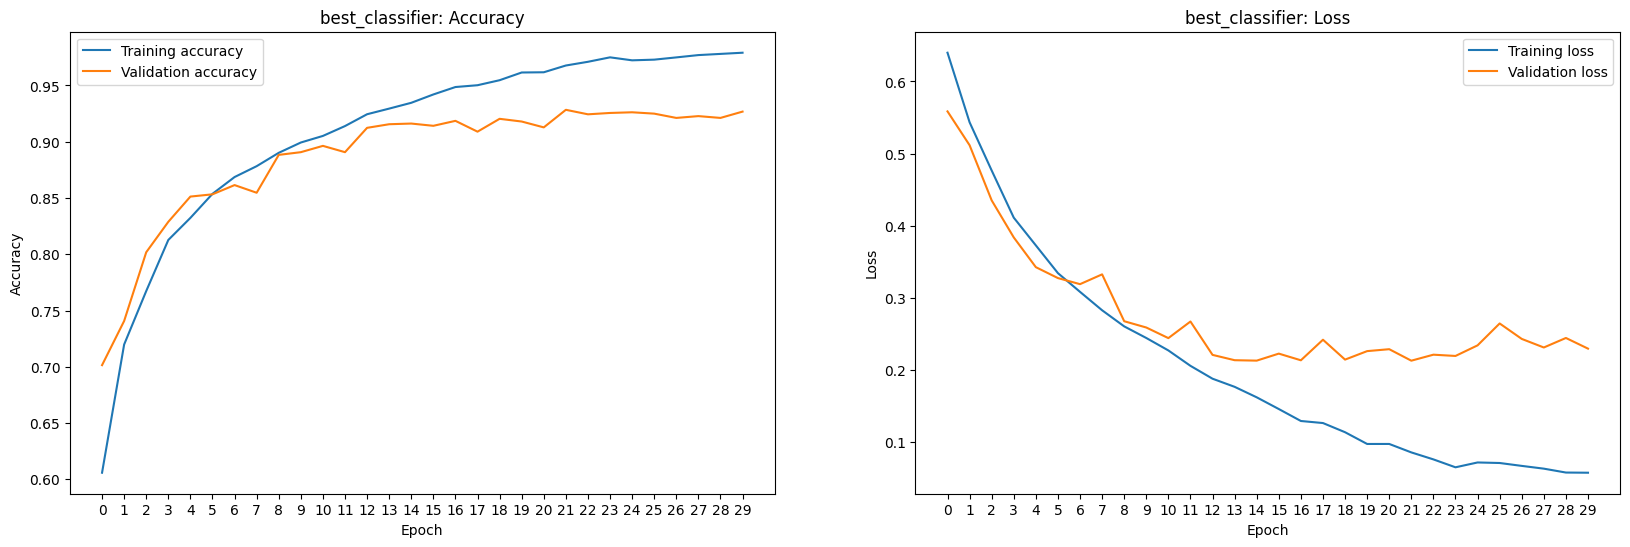

In [10]:
best_network.plot_results(save_dir=SAVE_DIR)

### Hyperparameter tuning - sweep architecture and optimization models

In [10]:
# randomly generate a network configuration
def generate_random_layer_config(layer_type):
    if layer_type == "Conv2D":
        return {
            "type": layer_type,
            "filters": random.choice([16, 32, 64, 128]),
            "kernel_size": random.choice([(3, 3), (5, 5)])
        }

    elif layer_type == "MaxPooling2D":
        return {
            "type": layer_type,
            "pool_size": random.choice([(2, 2), (3, 3)])
        }

    elif layer_type == "Dropout":
        return {
            "type": layer_type,
            "rate": random.uniform(0.5, 0.9)
        }

    elif layer_type == "Flatten":
        return {
            "type": layer_type
        }

    elif layer_type == "Dense":
        return {
            "type": layer_type,
            "units": random.choice([64, 128, 256, 512]),
            "activation": random.choice(["relu", "sigmoid", "tanh"])
        }


def generate_constrained_layer_config_list():
    layer_list = []

    # randomly choose the number of convolutional blocks
    num_conv_blocks = random.randint(1, 4)

    # ensure any conv layer is followed by max pooling layers
    for _ in range(num_conv_blocks):
        layer_list.append(generate_random_layer_config("Conv2D"))
        layer_list.append(generate_random_layer_config("MaxPooling2D"))

        # optionally add dropout layers after MaxPooling2D layers
        if random.random() < 0.5:
            layer_list.append(generate_random_layer_config("Dropout"))

    # add a Flatten layer before the first Dense layer
    layer_list.append(generate_random_layer_config("Flatten"))

    # randomly choose the number of dense layers (excluding the last one)
    num_dense_layers = random.randint(0, 2)

    for _ in range(num_dense_layers):
        layer_list.append(generate_random_layer_config("Dense"))

    # The last layer is Dense with softmax activation
    layer_list.append({
        "type": "Dense",
        "units": 2,
        "activation": "softmax"
    })

    return layer_list

In [77]:
# define an function to sweep architecutre params
def sweep_architecture_params(image_dir, n_trials, other_params):
    best_validation_acc = 0
    best_config = None

    for trial in range(n_trials):
        config = generate_constrained_layer_config_list()
        print("Testing architecture config (trial {}): {}".format(trial + 1, config))

        model = CatDogImageClassifier(
            model_name="architecture_sweep",
            batch_size=other_params["batch_size"],
            activation_function=other_params["activation_function"],
            loss_function=other_params["loss_function"],
            epochs=other_params["epochs"],
            layer_configs=config
        )

        try:
            model.build()
            model.train(image_dir)
            model.plot_results()
        except Exception as e:
            print("Failed to train: {}".format(e))
            continue

        # grab the highest-achieved validation accuracy
        current_validation_acc = max(model.validation_acc)

        if current_validation_acc > best_validation_acc:
            best_validation_acc = current_validation_acc
            best_config = config

        print("Current best validation accuracy: ", best_validation_acc)

    print("Best config: {}".format(best_config))
    return best_config


# define a function to sweep non-config params - (run after we decided on overall architecture)
def grid_search(image_dir, layer_configs, dropout_rates, batch_sizes, loss_functions, epochs_list):

    # Generate all combinations of parameters
    param_combinations = list(itertools.product(dropout_rates, batch_sizes, loss_functions, epochs_list))

    results = []

    for dropout_rate, batch_size, loss_function, epoch in param_combinations:
        model_name = f"model_dropout_{dropout_rate}_{batch_size}_{loss_function}_{epoch}"
        print(f"Training model: {model_name}")

        # create and build the model with the current parameter combination
        classifier = CatDogImageClassifier(
            model_name=model_name,
            batch_size=batch_size,
            activation_function='relu', # relu performs best based on the architecture sweep
            loss_function=loss_function,
            epochs=epoch,
            layer_configs=layer_configs,
            dropout_rate=dropout_rate
        )

        try:
            classifier.build()
            classifier.train(image_dir)
        except Exception as e:
            print("Failed to train network: {}. {}".format(model_name, e))

        # Append the results to the results list
        results.append({
            'model_name': model_name,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size,
            'loss_function': loss_function,
            'epochs': epoch,
            'accuracy': classifier.accuracy,
            'validation_accuracy': classifier.validation_acc,
            'loss': classifier.loss,
            'validation_loss': classifier.validation_loss
        })
        
    return results

def evaluate_model(params, image_dir, layer_configs):
    activation_function, learning_rate, batch_size, dropout_rate, dense_units = params
    
    model_name = f"model_{activation_function}_{learning_rate}_{batch_size}_{dropout_rate}_{dense_units}"
    print(f"Training model: {model_name}")

    classifier = CatDogImageClassifier(
        model_name=model_name,
        batch_size=batch_size,
        activation_function=activation_function,
        loss_function='binary_crossentropy',
        epochs=15,
        layer_configs=layer_configs,
        dropout_rate=None
    )

    try:
        classifier.build()
        classifier.train(image_dir)
    except Exception as e:
        print("Failed to train network: {}. {}".format(model_name, e))
        return 1.0  # Penalize the failed model

    # we want to maximize validation accuracy, so we minimize its negative value
    return -max(classifier.validation_acc)

def evaluate_model_wrapper(params):
    learning_rate, dropout_rate, dense_units, batch_size = params

    # Modify the best_config with the given hyperparameters
    config = best_config.copy()
    config[4]["rate"] = dropout_rate
    config[7]["rate"] = dropout_rate
    config[10]["rate"] = dropout_rate
    config[13]["units"] = dense_units

    # Evaluate the model with the modified configuration
    return evaluate_model(('relu', learning_rate, int(batch_size), dropout_rate, dense_units), BASE_IMAGE_DIR, config)




# Define the search space for hyperparameters
space = [Real(1e-4, 1e-2, name='learning_rate'),
         Real(0.2, 0.9, name='dropout_rate'),
         Integer(64, 256, name='dense_units'),
         Integer(16, 128, name='batch_size')
        ]

# GP optimization
result = gp_minimize(evaluate_model_wrapper, space, n_calls=20, n_random_starts=5, verbose=True)



Iteration No: 1 started. Evaluating function at random point.
Training model: model_relu_0.006790642659002284_53_0.4153507150676068_100
Building model: model_relu_0.006790642659002284_53_0.4153507150676068_100...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                         

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


377/377 [==============================] - 40s 101ms/step - loss: 0.6431 - acc: 0.6161 - val_loss: 0.5762 - val_acc: 0.6854
Epoch 2/15
377/377 [==============================] - 41s 107ms/step - loss: 0.5424 - acc: 0.7254 - val_loss: 0.5066 - val_acc: 0.7555
Epoch 3/15
377/377 [==============================] - 42s 112ms/step - loss: 0.4884 - acc: 0.7592 - val_loss: 0.4642 - val_acc: 0.7855
Epoch 4/15
377/377 [==============================] - 42s 109ms/step - loss: 0.4323 - acc: 0.7959 - val_loss: 0.4052 - val_acc: 0.8160
Epoch 5/15
377/377 [==============================] - 40s 104ms/step - loss: 0.3946 - acc: 0.8228 - val_loss: 0.3796 - val_acc: 0.8312
Epoch 6/15
377/377 [==============================] - 44s 115ms/step - loss: 0.3658 - acc: 0.8371 - val_loss: 0.3922 - val_acc: 0.8334
Epoch 7/15
377/377 [==============================] - 41s 108ms/step - loss: 0.3367 - acc: 0.8531 - val_loss: 0.3258 - val_acc: 0.8558
Epoch 8/15
377/377 [==============================] - 43s 113ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.006790642659002284_53_0.4153507150676068_100\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.006790642659002284_53_0.4153507150676068_100\assets


Iteration No: 1 ended. Evaluation done at random point.
Time taken: 628.5856
Function value obtained: -0.9043
Current minimum: -0.9043
Iteration No: 2 started. Evaluating function at random point.
Training model: model_relu_0.009694667807460311_41_0.4908749290141998_116
Building model: model_relu_0.009694667807460311_41_0.4908749290141998_116...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


488/488 [==============================] - 45s 90ms/step - loss: 0.6591 - acc: 0.5910 - val_loss: 0.5999 - val_acc: 0.6778
Epoch 2/15
488/488 [==============================] - 40s 81ms/step - loss: 0.5651 - acc: 0.7072 - val_loss: 0.5683 - val_acc: 0.6994
Epoch 3/15
488/488 [==============================] - 43s 88ms/step - loss: 0.4995 - acc: 0.7571 - val_loss: 0.4630 - val_acc: 0.7747
Epoch 4/15
488/488 [==============================] - 44s 91ms/step - loss: 0.4422 - acc: 0.7950 - val_loss: 0.4108 - val_acc: 0.8102
Epoch 5/15
488/488 [==============================] - 42s 85ms/step - loss: 0.3931 - acc: 0.8212 - val_loss: 0.3612 - val_acc: 0.8396
Epoch 6/15
488/488 [==============================] - 40s 81ms/step - loss: 0.3576 - acc: 0.8395 - val_loss: 0.3464 - val_acc: 0.8466
Epoch 7/15
488/488 [==============================] - 41s 83ms/step - loss: 0.3323 - acc: 0.8549 - val_loss: 0.3082 - val_acc: 0.8674
Epoch 8/15
488/488 [==============================] - 44s 89ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.009694667807460311_41_0.4908749290141998_116\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.009694667807460311_41_0.4908749290141998_116\assets


Iteration No: 2 ended. Evaluation done at random point.
Time taken: 640.5295
Function value obtained: -0.9121
Current minimum: -0.9121
Iteration No: 3 started. Evaluating function at random point.
Training model: model_relu_0.006665771619724108_80_0.40234509813329333_221
Building model: model_relu_0.006665771619724108_80_0.40234509813329333_221...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None,

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


250/250 [==============================] - 38s 145ms/step - loss: 0.6654 - acc: 0.5843 - val_loss: 0.6499 - val_acc: 0.6151
Epoch 2/15
250/250 [==============================] - 36s 143ms/step - loss: 0.5926 - acc: 0.6739 - val_loss: 0.5563 - val_acc: 0.6962
Epoch 3/15
250/250 [==============================] - 39s 153ms/step - loss: 0.5358 - acc: 0.7270 - val_loss: 0.5016 - val_acc: 0.7577
Epoch 4/15
250/250 [==============================] - 33s 129ms/step - loss: 0.4921 - acc: 0.7623 - val_loss: 0.4719 - val_acc: 0.7735
Epoch 5/15
250/250 [==============================] - 33s 131ms/step - loss: 0.4457 - acc: 0.7887 - val_loss: 0.4369 - val_acc: 0.7970
Epoch 6/15
250/250 [==============================] - 34s 136ms/step - loss: 0.4046 - acc: 0.8192 - val_loss: 0.3896 - val_acc: 0.8280
Epoch 7/15
250/250 [==============================] - 37s 146ms/step - loss: 0.3765 - acc: 0.8320 - val_loss: 0.3824 - val_acc: 0.8290
Epoch 8/15
250/250 [==============================] - 33s 131ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.006665771619724108_80_0.40234509813329333_221\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.006665771619724108_80_0.40234509813329333_221\assets


Iteration No: 3 ended. Evaluation done at random point.
Time taken: 537.4420
Function value obtained: -0.8911
Current minimum: -0.9121
Iteration No: 4 started. Evaluating function at random point.
Training model: model_relu_0.00199999244159046_109_0.3935636217188563_194
Building model: model_relu_0.00199999244159046_109_0.3935636217188563_194...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 4

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


184/184 [==============================] - 36s 181ms/step - loss: 0.6768 - acc: 0.5472 - val_loss: 0.6347 - val_acc: 0.6227
Epoch 2/15
184/184 [==============================] - 37s 193ms/step - loss: 0.5926 - acc: 0.6708 - val_loss: 0.5556 - val_acc: 0.7203
Epoch 3/15
184/184 [==============================] - 34s 176ms/step - loss: 0.5389 - acc: 0.7268 - val_loss: 0.5105 - val_acc: 0.7471
Epoch 4/15
184/184 [==============================] - 35s 184ms/step - loss: 0.4941 - acc: 0.7574 - val_loss: 0.4711 - val_acc: 0.7741
Epoch 5/15
184/184 [==============================] - 37s 199ms/step - loss: 0.4687 - acc: 0.7741 - val_loss: 0.4460 - val_acc: 0.7966
Epoch 6/15
184/184 [==============================] - 32s 169ms/step - loss: 0.4247 - acc: 0.8018 - val_loss: 0.3989 - val_acc: 0.8220
Epoch 7/15
184/184 [==============================] - 36s 188ms/step - loss: 0.3953 - acc: 0.8202 - val_loss: 0.3921 - val_acc: 0.8188
Epoch 8/15
184/184 [==============================] - 32s 169ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.00199999244159046_109_0.3935636217188563_194\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.00199999244159046_109_0.3935636217188563_194\assets


Iteration No: 4 ended. Evaluation done at random point.
Time taken: 527.4559
Function value obtained: -0.8913
Current minimum: -0.9121
Iteration No: 5 started. Evaluating function at random point.
Training model: model_relu_0.00192530922260096_50_0.524177077660944_173
Building model: model_relu_0.00192530922260096_50_0.524177077660944_173...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 4

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


400/400 [==============================] - 45s 107ms/step - loss: 0.6827 - acc: 0.5475 - val_loss: 0.6548 - val_acc: 0.6153
Epoch 2/15
400/400 [==============================] - 41s 102ms/step - loss: 0.6238 - acc: 0.6405 - val_loss: 0.5819 - val_acc: 0.6800
Epoch 3/15
400/400 [==============================] - 39s 97ms/step - loss: 0.5637 - acc: 0.7023 - val_loss: 0.5316 - val_acc: 0.7281
Epoch 4/15
400/400 [==============================] - 38s 94ms/step - loss: 0.5197 - acc: 0.7394 - val_loss: 0.4944 - val_acc: 0.7641
Epoch 5/15
400/400 [==============================] - 40s 100ms/step - loss: 0.4785 - acc: 0.7698 - val_loss: 0.4516 - val_acc: 0.7899
Epoch 6/15
400/400 [==============================] - 42s 105ms/step - loss: 0.4375 - acc: 0.7968 - val_loss: 0.4038 - val_acc: 0.8242
Epoch 7/15
400/400 [==============================] - 42s 103ms/step - loss: 0.3992 - acc: 0.8196 - val_loss: 0.3908 - val_acc: 0.8218
Epoch 8/15
400/400 [==============================] - 42s 103ms/step

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.00192530922260096_50_0.524177077660944_173\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.00192530922260096_50_0.524177077660944_173\assets


Iteration No: 5 ended. Evaluation done at random point.
Time taken: 616.4610
Function value obtained: -0.9013
Current minimum: -0.9121
Iteration No: 6 started. Searching for the next optimal point.
Training model: model_relu_0.007742092918338883_63_0.5366691926216446_65
Building model: model_relu_0.007742092918338883_63_0.5366691926216446_65...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


318/318 [==============================] - 41s 124ms/step - loss: 0.6788 - acc: 0.5631 - val_loss: 0.6351 - val_acc: 0.6412
Epoch 2/15
318/318 [==============================] - 42s 129ms/step - loss: 0.5997 - acc: 0.6756 - val_loss: 0.5984 - val_acc: 0.6804
Epoch 3/15
318/318 [==============================] - 49s 151ms/step - loss: 0.5465 - acc: 0.7248 - val_loss: 0.5200 - val_acc: 0.7503
Epoch 4/15
318/318 [==============================] - 40s 125ms/step - loss: 0.5054 - acc: 0.7505 - val_loss: 0.4806 - val_acc: 0.7723
Epoch 5/15
318/318 [==============================] - 38s 119ms/step - loss: 0.4746 - acc: 0.7698 - val_loss: 0.4568 - val_acc: 0.7863
Epoch 6/15
318/318 [==============================] - 38s 120ms/step - loss: 0.4429 - acc: 0.7911 - val_loss: 0.4185 - val_acc: 0.8084
Epoch 7/15
318/318 [==============================] - 42s 130ms/step - loss: 0.4177 - acc: 0.8067 - val_loss: 0.4011 - val_acc: 0.8170
Epoch 8/15
318/318 [==============================] - 39s 120ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.007742092918338883_63_0.5366691926216446_65\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.007742092918338883_63_0.5366691926216446_65\assets


Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 626.8684
Function value obtained: -0.8917
Current minimum: -0.9121
Iteration No: 7 started. Searching for the next optimal point.
Training model: model_relu_0.01_23_0.3621668997754742_114
Building model: model_relu_0.01_23_0.3621668997754742_114...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0  

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


869/869 [==============================] - 50s 56ms/step - loss: 0.6143 - acc: 0.6464 - val_loss: 0.5467 - val_acc: 0.7177
Epoch 2/15
869/869 [==============================] - 44s 50ms/step - loss: 0.5274 - acc: 0.7322 - val_loss: 0.4832 - val_acc: 0.7669
Epoch 3/15
869/869 [==============================] - 46s 53ms/step - loss: 0.4613 - acc: 0.7803 - val_loss: 0.4341 - val_acc: 0.7907
Epoch 4/15
869/869 [==============================] - 42s 48ms/step - loss: 0.3960 - acc: 0.8206 - val_loss: 0.3824 - val_acc: 0.8318
Epoch 5/15
869/869 [==============================] - 46s 53ms/step - loss: 0.3540 - acc: 0.8419 - val_loss: 0.3297 - val_acc: 0.8578
Epoch 6/15
869/869 [==============================] - 47s 54ms/step - loss: 0.3201 - acc: 0.8594 - val_loss: 0.3181 - val_acc: 0.8614
Epoch 7/15
869/869 [==============================] - 42s 48ms/step - loss: 0.2916 - acc: 0.8746 - val_loss: 0.3173 - val_acc: 0.8584
Epoch 8/15
869/869 [==============================] - 46s 53ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.01_23_0.3621668997754742_114\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.01_23_0.3621668997754742_114\assets


Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 675.7959
Function value obtained: -0.9115
Current minimum: -0.9121
Iteration No: 8 started. Searching for the next optimal point.
Training model: model_relu_0.01_17_0.2_143
Building model: model_relu_0.01_17_0.2_143...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                  

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1176/1176 [==============================] - 45s 38ms/step - loss: 0.6656 - acc: 0.5846 - val_loss: 0.6090 - val_acc: 0.6704
Epoch 2/15
1176/1176 [==============================] - 45s 38ms/step - loss: 0.5622 - acc: 0.7061 - val_loss: 0.4957 - val_acc: 0.7643
Epoch 3/15
1176/1176 [==============================] - 42s 36ms/step - loss: 0.4922 - acc: 0.7603 - val_loss: 0.4399 - val_acc: 0.7960
Epoch 4/15
1176/1176 [==============================] - 50s 42ms/step - loss: 0.4258 - acc: 0.8002 - val_loss: 0.4138 - val_acc: 0.8178
Epoch 5/15
1176/1176 [==============================] - 48s 41ms/step - loss: 0.3602 - acc: 0.8392 - val_loss: 0.3646 - val_acc: 0.8298
Epoch 6/15
1176/1176 [==============================] - 44s 38ms/step - loss: 0.3146 - acc: 0.8625 - val_loss: 0.3152 - val_acc: 0.8634
Epoch 7/15
1176/1176 [==============================] - 42s 36ms/step - loss: 0.2832 - acc: 0.8798 - val_loss: 0.2927 - val_acc: 0.8751
Epoch 8/15
1176/1176 [==============================] - 50s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.01_17_0.2_143\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.01_17_0.2_143\assets


Iteration No: 8 ended. Search finished for the next optimal point.
Time taken: 693.2993
Function value obtained: -0.9113
Current minimum: -0.9121
Iteration No: 9 started. Searching for the next optimal point.
Training model: model_relu_0.0023827355834522084_29_0.8690953586294254_256
Building model: model_relu_0.0023827355834522084_29_0.8690953586294254_256...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPoo

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


689/689 [==============================] - 46s 65ms/step - loss: 0.6617 - acc: 0.5900 - val_loss: 0.6913 - val_acc: 0.5515
Epoch 2/15
689/689 [==============================] - 48s 69ms/step - loss: 0.6122 - acc: 0.6489 - val_loss: 0.6279 - val_acc: 0.6314
Epoch 3/15
689/689 [==============================] - 43s 63ms/step - loss: 0.5935 - acc: 0.6675 - val_loss: 0.6291 - val_acc: 0.6282
Epoch 4/15
689/689 [==============================] - 45s 65ms/step - loss: 0.5780 - acc: 0.6862 - val_loss: 0.6273 - val_acc: 0.6790
Epoch 5/15
689/689 [==============================] - 67s 97ms/step - loss: 0.5646 - acc: 0.6997 - val_loss: 0.6347 - val_acc: 0.6304
Epoch 6/15
689/689 [==============================] - 40s 58ms/step - loss: 0.5538 - acc: 0.7106 - val_loss: 0.6241 - val_acc: 0.6868
Epoch 7/15
689/689 [==============================] - 43s 62ms/step - loss: 0.5413 - acc: 0.7186 - val_loss: 0.6589 - val_acc: 0.6484
Epoch 8/15
689/689 [==============================] - 42s 60ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.0023827355834522084_29_0.8690953586294254_256\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.0023827355834522084_29_0.8690953586294254_256\assets


Iteration No: 9 ended. Search finished for the next optimal point.
Time taken: 667.2775
Function value obtained: -0.6868
Current minimum: -0.9121
Iteration No: 10 started. Searching for the next optimal point.
Training model: model_relu_0.009489541240873502_16_0.27948350463720023_64
Building model: model_relu_0.009489541240873502_16_0.27948350463720023_64...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPool

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 76s 60ms/step - loss: 0.6190 - acc: 0.6417 - val_loss: 0.5647 - val_acc: 0.7036
Epoch 2/15
1249/1249 [==============================] - 69s 55ms/step - loss: 0.5205 - acc: 0.7377 - val_loss: 0.4880 - val_acc: 0.7665
Epoch 3/15
1249/1249 [==============================] - 74s 59ms/step - loss: 0.4415 - acc: 0.7937 - val_loss: 0.3893 - val_acc: 0.8240
Epoch 4/15
1249/1249 [==============================] - 75s 60ms/step - loss: 0.3796 - acc: 0.8278 - val_loss: 0.3542 - val_acc: 0.8438
Epoch 5/15
1249/1249 [==============================] - 71s 57ms/step - loss: 0.3288 - acc: 0.8555 - val_loss: 0.3389 - val_acc: 0.8558
Epoch 6/15
1249/1249 [==============================] - 69s 55ms/step - loss: 0.2934 - acc: 0.8740 - val_loss: 0.2974 - val_acc: 0.8742
Epoch 7/15
1249/1249 [==============================] - 70s 56ms/step - loss: 0.2567 - acc: 0.8915 - val_loss: 0.2623 - val_acc: 0.8865
Epoch 8/15
1249/1249 [==============================] - 72s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.009489541240873502_16_0.27948350463720023_64\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.009489541240873502_16_0.27948350463720023_64\assets


Iteration No: 10 ended. Search finished for the next optimal point.
Time taken: 1087.0108
Function value obtained: -0.9265
Current minimum: -0.9265
Iteration No: 11 started. Searching for the next optimal point.
Training model: model_relu_0.01_128_0.24395250930666107_64
Building model: model_relu_0.01_128_0.24395250930666107_64...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)     

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


157/157 [==============================] - 34s 206ms/step - loss: 0.6494 - acc: 0.6045 - val_loss: 0.5857 - val_acc: 0.6884
Epoch 2/15
157/157 [==============================] - 35s 215ms/step - loss: 0.5714 - acc: 0.6997 - val_loss: 0.5560 - val_acc: 0.7085
Epoch 3/15
157/157 [==============================] - 35s 220ms/step - loss: 0.5344 - acc: 0.7315 - val_loss: 0.5068 - val_acc: 0.7473
Epoch 4/15
157/157 [==============================] - 32s 198ms/step - loss: 0.5017 - acc: 0.7515 - val_loss: 0.4806 - val_acc: 0.7711
Epoch 5/15
157/157 [==============================] - 33s 207ms/step - loss: 0.4584 - acc: 0.7817 - val_loss: 0.4464 - val_acc: 0.7883
Epoch 6/15
157/157 [==============================] - 34s 211ms/step - loss: 0.4350 - acc: 0.7977 - val_loss: 0.4167 - val_acc: 0.8088
Epoch 7/15
157/157 [==============================] - 37s 229ms/step - loss: 0.3894 - acc: 0.8248 - val_loss: 0.3724 - val_acc: 0.8376
Epoch 8/15
157/157 [==============================] - 32s 197ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.01_128_0.24395250930666107_64\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.01_128_0.24395250930666107_64\assets


Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 512.4311
Function value obtained: -0.8849
Current minimum: -0.9265
Iteration No: 12 started. Searching for the next optimal point.
Training model: model_relu_0.0001_16_0.27295096633129945_256
Building model: model_relu_0.0001_16_0.27295096633129945_256...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)  

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 78s 62ms/step - loss: 0.6141 - acc: 0.6426 - val_loss: 0.5371 - val_acc: 0.7219
Epoch 2/15
1249/1249 [==============================] - 72s 58ms/step - loss: 0.5193 - acc: 0.7366 - val_loss: 0.5104 - val_acc: 0.7471
Epoch 3/15
1249/1249 [==============================] - 71s 56ms/step - loss: 0.4365 - acc: 0.7922 - val_loss: 0.4130 - val_acc: 0.8136
Epoch 4/15
1249/1249 [==============================] - 74s 59ms/step - loss: 0.3722 - acc: 0.8326 - val_loss: 0.3463 - val_acc: 0.8450
Epoch 5/15
1249/1249 [==============================] - 74s 59ms/step - loss: 0.3208 - acc: 0.8614 - val_loss: 0.3674 - val_acc: 0.8404
Epoch 6/15
1249/1249 [==============================] - 69s 55ms/step - loss: 0.2860 - acc: 0.8774 - val_loss: 0.2994 - val_acc: 0.8757
Epoch 7/15
1249/1249 [==============================] - 73s 58ms/step - loss: 0.2523 - acc: 0.8923 - val_loss: 0.2457 - val_acc: 0.8957
Epoch 8/15
1249/1249 [==============================] - 69s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.0001_16_0.27295096633129945_256\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.0001_16_0.27295096633129945_256\assets


Iteration No: 12 ended. Search finished for the next optimal point.
Time taken: 1099.6715
Function value obtained: -0.9209
Current minimum: -0.9265
Iteration No: 13 started. Searching for the next optimal point.
Training model: model_relu_0.0001_16_0.4667854762630209_256
Building model: model_relu_0.0001_16_0.4667854762630209_256...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)   

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 76s 60ms/step - loss: 0.6194 - acc: 0.6383 - val_loss: 0.5473 - val_acc: 0.7082
Epoch 2/15
1249/1249 [==============================] - 76s 61ms/step - loss: 0.5177 - acc: 0.7415 - val_loss: 0.4562 - val_acc: 0.7859
Epoch 3/15
1249/1249 [==============================] - 72s 58ms/step - loss: 0.4413 - acc: 0.7932 - val_loss: 0.4002 - val_acc: 0.8192
Epoch 4/15
1249/1249 [==============================] - 76s 61ms/step - loss: 0.3939 - acc: 0.8232 - val_loss: 0.3766 - val_acc: 0.8290
Epoch 5/15
1249/1249 [==============================] - 71s 56ms/step - loss: 0.3562 - acc: 0.8413 - val_loss: 0.3275 - val_acc: 0.8546
Epoch 6/15
1249/1249 [==============================] - 79s 63ms/step - loss: 0.3221 - acc: 0.8602 - val_loss: 0.2989 - val_acc: 0.8744
Epoch 7/15
1249/1249 [==============================] - 72s 57ms/step - loss: 0.2991 - acc: 0.8710 - val_loss: 0.2912 - val_acc: 0.8779
Epoch 8/15
1249/1249 [==============================] - 73s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.0001_16_0.4667854762630209_256\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.0001_16_0.4667854762630209_256\assets


Iteration No: 13 ended. Search finished for the next optimal point.
Time taken: 1124.8528
Function value obtained: -0.9153
Current minimum: -0.9265
Iteration No: 14 started. Searching for the next optimal point.
Training model: model_relu_0.0001_16_0.2874287497875939_64
Building model: model_relu_0.0001_16_0.2874287497875939_64...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)     

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 79s 62ms/step - loss: 0.6147 - acc: 0.6449 - val_loss: 0.5249 - val_acc: 0.7431
Epoch 2/15
1249/1249 [==============================] - 71s 57ms/step - loss: 0.4930 - acc: 0.7578 - val_loss: 0.4449 - val_acc: 0.7903
Epoch 3/15
1249/1249 [==============================] - 75s 60ms/step - loss: 0.4132 - acc: 0.8111 - val_loss: 0.3910 - val_acc: 0.8258
Epoch 4/15
1249/1249 [==============================] - 75s 60ms/step - loss: 0.3536 - acc: 0.8422 - val_loss: 0.3614 - val_acc: 0.8412
Epoch 5/15
1249/1249 [==============================] - 74s 59ms/step - loss: 0.3042 - acc: 0.8684 - val_loss: 0.2925 - val_acc: 0.8777
Epoch 6/15
1249/1249 [==============================] - 80s 64ms/step - loss: 0.2717 - acc: 0.8840 - val_loss: 0.2837 - val_acc: 0.8751
Epoch 7/15
1249/1249 [==============================] - 72s 58ms/step - loss: 0.2476 - acc: 0.8947 - val_loss: 0.2527 - val_acc: 0.8895
Epoch 8/15
1249/1249 [==============================] - 75s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.0001_16_0.2874287497875939_64\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.0001_16_0.2874287497875939_64\assets


Iteration No: 14 ended. Search finished for the next optimal point.
Time taken: 1129.0059
Function value obtained: -0.9195
Current minimum: -0.9265
Iteration No: 15 started. Searching for the next optimal point.
Training model: model_relu_0.008689063115528287_16_0.6251905683009528_175
Building model: model_relu_0.008689063115528287_16_0.6251905683009528_175...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPo

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 75s 60ms/step - loss: 0.6380 - acc: 0.6178 - val_loss: 0.6034 - val_acc: 0.6508
Epoch 2/15
1249/1249 [==============================] - 77s 62ms/step - loss: 0.5649 - acc: 0.7036 - val_loss: 0.5489 - val_acc: 0.7085
Epoch 3/15
1249/1249 [==============================] - 79s 63ms/step - loss: 0.5097 - acc: 0.7429 - val_loss: 0.4818 - val_acc: 0.7705
Epoch 4/15
1249/1249 [==============================] - 75s 60ms/step - loss: 0.4553 - acc: 0.7832 - val_loss: 0.4305 - val_acc: 0.7946
Epoch 5/15
1249/1249 [==============================] - 77s 62ms/step - loss: 0.4066 - acc: 0.8154 - val_loss: 0.4173 - val_acc: 0.8196
Epoch 6/15
1249/1249 [==============================] - 76s 61ms/step - loss: 0.3732 - acc: 0.8343 - val_loss: 0.3666 - val_acc: 0.8306
Epoch 7/15
1249/1249 [==============================] - 70s 56ms/step - loss: 0.3503 - acc: 0.8489 - val_loss: 0.3377 - val_acc: 0.8612
Epoch 8/15
1249/1249 [==============================] - 70s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.008689063115528287_16_0.6251905683009528_175\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.008689063115528287_16_0.6251905683009528_175\assets


Iteration No: 15 ended. Search finished for the next optimal point.
Time taken: 1115.3080
Function value obtained: -0.9065
Current minimum: -0.9265
Iteration No: 16 started. Searching for the next optimal point.
Training model: model_relu_0.01_16_0.5455994500568944_64
Building model: model_relu_0.01_16_0.5455994500568944_64...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0 

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 78s 62ms/step - loss: 0.6609 - acc: 0.5917 - val_loss: 0.6181 - val_acc: 0.6800
Epoch 2/15
1249/1249 [==============================] - 71s 57ms/step - loss: 0.5718 - acc: 0.7015 - val_loss: 0.5153 - val_acc: 0.7453
Epoch 3/15
1249/1249 [==============================] - 75s 60ms/step - loss: 0.5125 - acc: 0.7415 - val_loss: 0.4725 - val_acc: 0.7771
Epoch 4/15
1249/1249 [==============================] - 71s 57ms/step - loss: 0.4666 - acc: 0.7763 - val_loss: 0.4325 - val_acc: 0.8006
Epoch 5/15
1249/1249 [==============================] - 73s 59ms/step - loss: 0.4141 - acc: 0.8106 - val_loss: 0.4081 - val_acc: 0.8132
Epoch 6/15
1249/1249 [==============================] - 78s 62ms/step - loss: 0.3778 - acc: 0.8313 - val_loss: 0.3511 - val_acc: 0.8470
Epoch 7/15
1249/1249 [==============================] - 75s 60ms/step - loss: 0.3378 - acc: 0.8508 - val_loss: 0.3139 - val_acc: 0.8668
Epoch 8/15
1249/1249 [==============================] - 80s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.01_16_0.5455994500568944_64\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.01_16_0.5455994500568944_64\assets


Iteration No: 16 ended. Search finished for the next optimal point.
Time taken: 1133.0319
Function value obtained: -0.9041
Current minimum: -0.9265
Iteration No: 17 started. Searching for the next optimal point.
Training model: model_relu_0.01_128_0.6749589133173618_64
Building model: model_relu_0.01_128_0.6749589133173618_64...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


157/157 [==============================] - 34s 207ms/step - loss: 0.6764 - acc: 0.5729 - val_loss: 0.7296 - val_acc: 0.5170
Epoch 2/15
157/157 [==============================] - 35s 215ms/step - loss: 0.6361 - acc: 0.6324 - val_loss: 0.6176 - val_acc: 0.6540
Epoch 3/15
157/157 [==============================] - 38s 237ms/step - loss: 0.6026 - acc: 0.6698 - val_loss: 0.6223 - val_acc: 0.6328
Epoch 4/15
157/157 [==============================] - 40s 247ms/step - loss: 0.5568 - acc: 0.7164 - val_loss: 0.5863 - val_acc: 0.6826
Epoch 5/15
157/157 [==============================] - 39s 241ms/step - loss: 0.5216 - acc: 0.7426 - val_loss: 0.5729 - val_acc: 0.6914
Epoch 6/15
157/157 [==============================] - 32s 199ms/step - loss: 0.4865 - acc: 0.7661 - val_loss: 0.5268 - val_acc: 0.7345
Epoch 7/15
157/157 [==============================] - 34s 212ms/step - loss: 0.4615 - acc: 0.7840 - val_loss: 0.5163 - val_acc: 0.7377
Epoch 8/15
157/157 [==============================] - 40s 249ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.01_128_0.6749589133173618_64\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.01_128_0.6749589133173618_64\assets


Iteration No: 17 ended. Search finished for the next optimal point.
Time taken: 537.1988
Function value obtained: -0.8384
Current minimum: -0.9265
Iteration No: 18 started. Searching for the next optimal point.
Training model: model_relu_0.006781429805475959_16_0.23825359571356158_209
Building model: model_relu_0.006781429805475959_16_0.23825359571356158_209...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxP

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 75s 60ms/step - loss: 0.6208 - acc: 0.6296 - val_loss: 0.5310 - val_acc: 0.7315
Epoch 2/15
1249/1249 [==============================] - 71s 57ms/step - loss: 0.5052 - acc: 0.7476 - val_loss: 0.4486 - val_acc: 0.7837
Epoch 3/15
1249/1249 [==============================] - 76s 61ms/step - loss: 0.4219 - acc: 0.8045 - val_loss: 0.3706 - val_acc: 0.8316
Epoch 4/15
1249/1249 [==============================] - 72s 57ms/step - loss: 0.3608 - acc: 0.8412 - val_loss: 0.3642 - val_acc: 0.8364
Epoch 5/15
1249/1249 [==============================] - 69s 55ms/step - loss: 0.3115 - acc: 0.8639 - val_loss: 0.3130 - val_acc: 0.8686
Epoch 6/15
1249/1249 [==============================] - 75s 60ms/step - loss: 0.2749 - acc: 0.8834 - val_loss: 0.2911 - val_acc: 0.8744
Epoch 7/15
1249/1249 [==============================] - 70s 56ms/step - loss: 0.2443 - acc: 0.8992 - val_loss: 0.2479 - val_acc: 0.8955
Epoch 8/15
1249/1249 [==============================] - 73s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.006781429805475959_16_0.23825359571356158_209\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.006781429805475959_16_0.23825359571356158_209\assets


Iteration No: 18 ended. Search finished for the next optimal point.
Time taken: 1103.5412
Function value obtained: -0.9169
Current minimum: -0.9265
Iteration No: 19 started. Searching for the next optimal point.
Training model: model_relu_0.009740932476511324_18_0.310823508639146_237
Building model: model_relu_0.009740932476511324_18_0.310823508639146_237...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPool

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1111/1111 [==============================] - 47s 41ms/step - loss: 0.6391 - acc: 0.6058 - val_loss: 0.5358 - val_acc: 0.7327
Epoch 2/15
1111/1111 [==============================] - 46s 41ms/step - loss: 0.5306 - acc: 0.7308 - val_loss: 0.5006 - val_acc: 0.7519
Epoch 3/15
1111/1111 [==============================] - 43s 39ms/step - loss: 0.4685 - acc: 0.7759 - val_loss: 0.4197 - val_acc: 0.8072
Epoch 4/15
1111/1111 [==============================] - 45s 40ms/step - loss: 0.4159 - acc: 0.8086 - val_loss: 0.3956 - val_acc: 0.8200
Epoch 5/15
1111/1111 [==============================] - 49s 44ms/step - loss: 0.3700 - acc: 0.8343 - val_loss: 0.3487 - val_acc: 0.8536
Epoch 6/15
1111/1111 [==============================] - 45s 41ms/step - loss: 0.3353 - acc: 0.8566 - val_loss: 0.3296 - val_acc: 0.8520
Epoch 7/15
1111/1111 [==============================] - 51s 46ms/step - loss: 0.3014 - acc: 0.8703 - val_loss: 0.3113 - val_acc: 0.8670
Epoch 8/15
1111/1111 [==============================] - 51s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.009740932476511324_18_0.310823508639146_237\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.009740932476511324_18_0.310823508639146_237\assets


Iteration No: 19 ended. Search finished for the next optimal point.
Time taken: 710.2387
Function value obtained: -0.9073
Current minimum: -0.9265
Iteration No: 20 started. Searching for the next optimal point.
Training model: model_relu_0.0001_16_0.25623010160630405_64
Building model: model_relu_0.0001_16_0.25623010160630405_64...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)    

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 80s 63ms/step - loss: 0.6612 - acc: 0.5952 - val_loss: 0.6126 - val_acc: 0.6840
Epoch 2/15
1249/1249 [==============================] - 75s 60ms/step - loss: 0.5666 - acc: 0.7054 - val_loss: 0.5168 - val_acc: 0.7479
Epoch 3/15
1249/1249 [==============================] - 72s 57ms/step - loss: 0.4995 - acc: 0.7566 - val_loss: 0.4657 - val_acc: 0.7791
Epoch 4/15
1249/1249 [==============================] - 70s 56ms/step - loss: 0.4298 - acc: 0.8008 - val_loss: 0.3937 - val_acc: 0.8200
Epoch 5/15
1249/1249 [==============================] - 72s 57ms/step - loss: 0.3614 - acc: 0.8403 - val_loss: 0.3327 - val_acc: 0.8574
Epoch 6/15
1249/1249 [==============================] - 72s 58ms/step - loss: 0.3083 - acc: 0.8668 - val_loss: 0.2945 - val_acc: 0.8789
Epoch 7/15
1249/1249 [==============================] - 72s 57ms/step - loss: 0.2711 - acc: 0.8847 - val_loss: 0.2799 - val_acc: 0.8821
Epoch 8/15
1249/1249 [==============================] - 72s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.0001_16_0.25623010160630405_64\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_0.0001_16_0.25623010160630405_64\assets


Iteration No: 20 ended. Search finished for the next optimal point.
Time taken: 1094.9465
Function value obtained: -0.9231
Current minimum: -0.9265


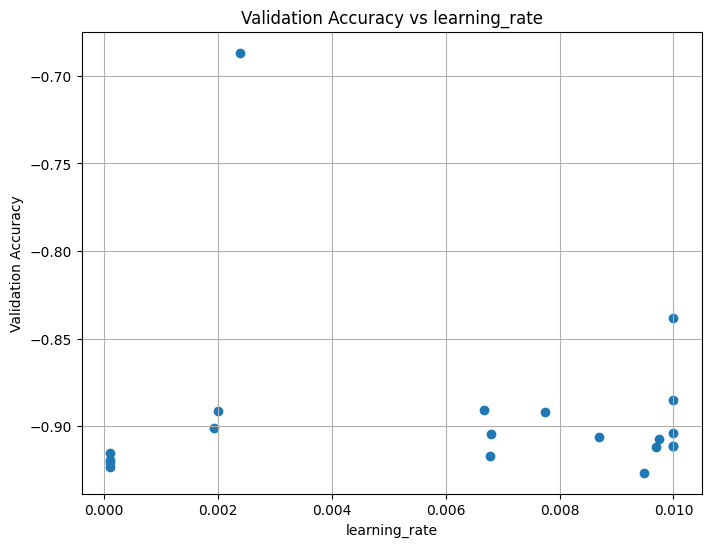

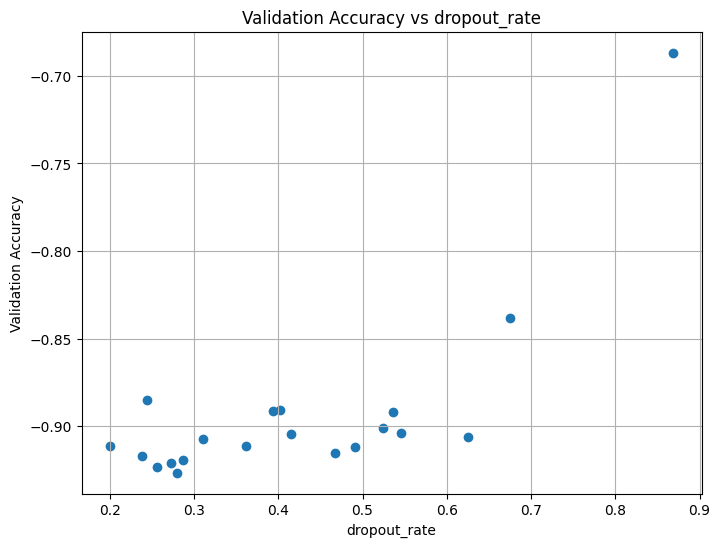

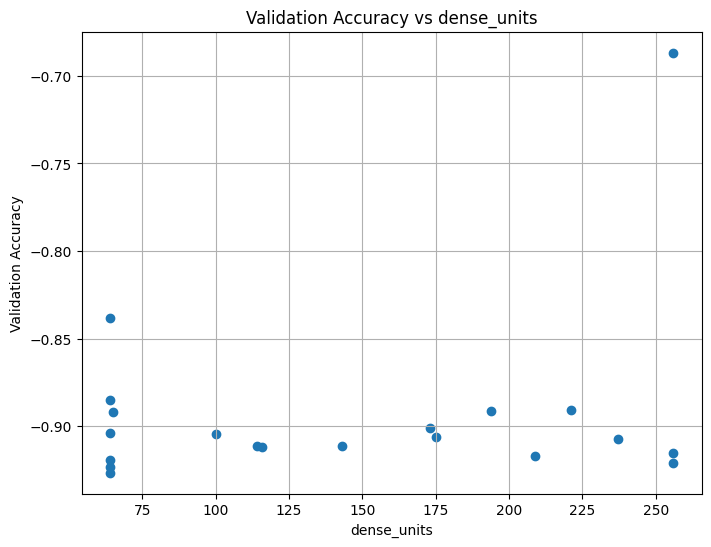

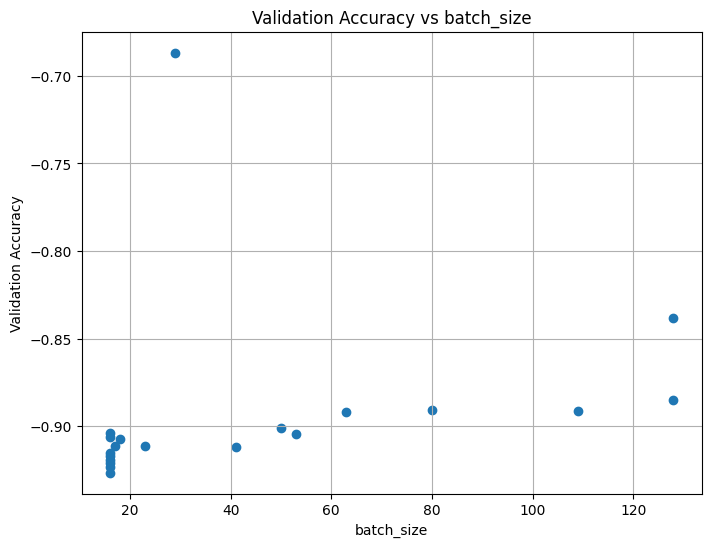

In [90]:
def plot_all_variables_vs_performance(results, param_names):
    x_iters = results.x_iters
    y_values = results.func_vals
    
    for i, variable_name in enumerate(param_names):
        x_values = [x[i] for x in x_iters]

        plt.figure(figsize=(8, 6))
        plt.scatter(x_values, y_values)
        plt.xlabel(variable_name)
        plt.ylabel('Validation Accuracy')
        plt.title('Validation Accuracy vs {}'.format(variable_name))
        plt.grid()
        plt.show()

param_names = ['learning_rate', 'dropout_rate', 'dense_units', 'batch_size']
plot_all_variables_vs_performance(result, param_names)






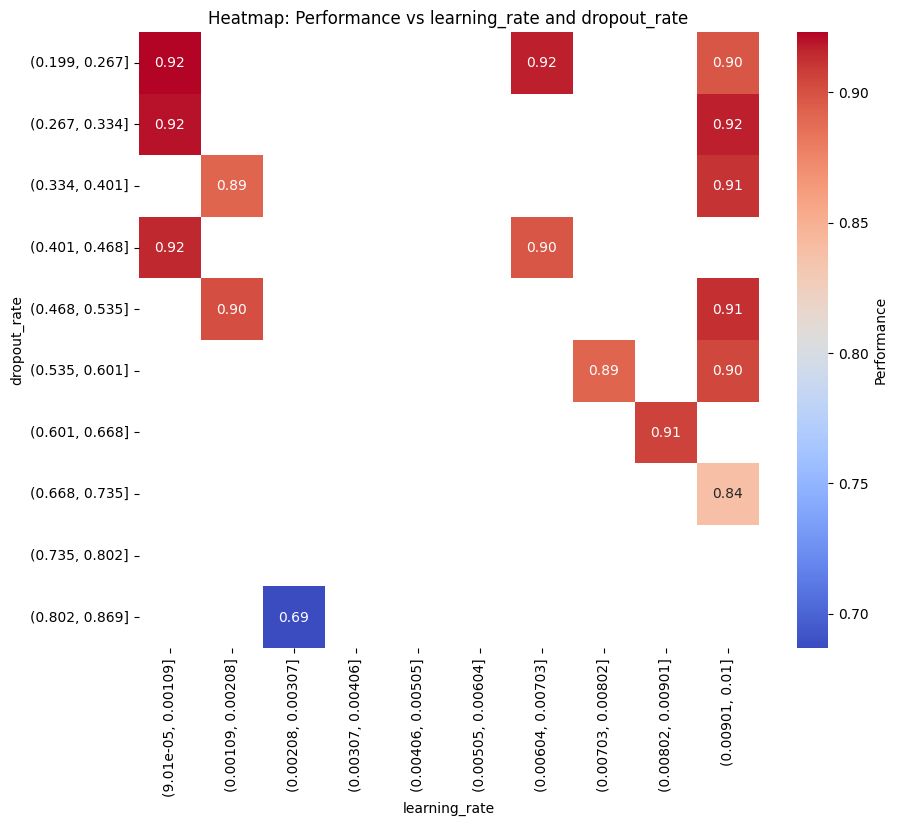

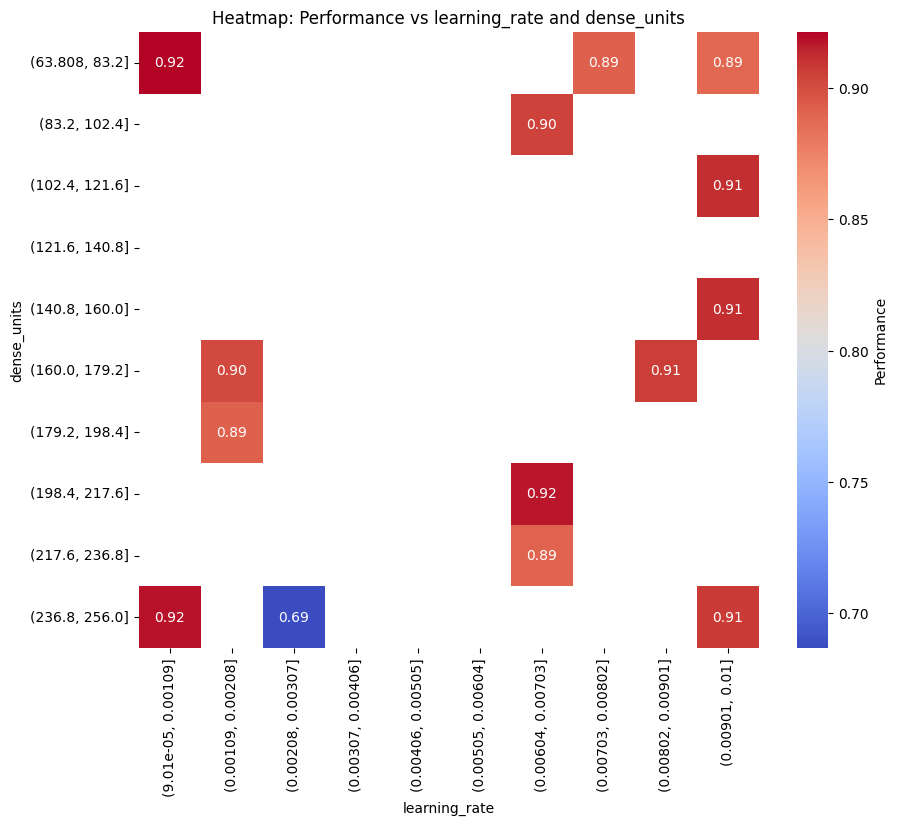

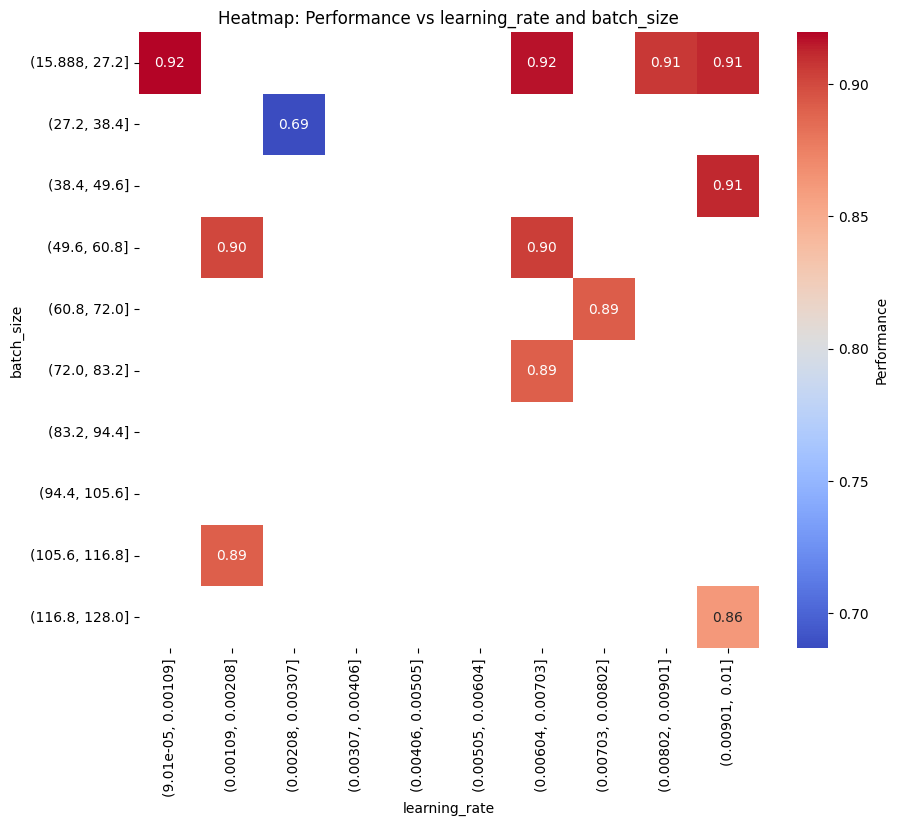

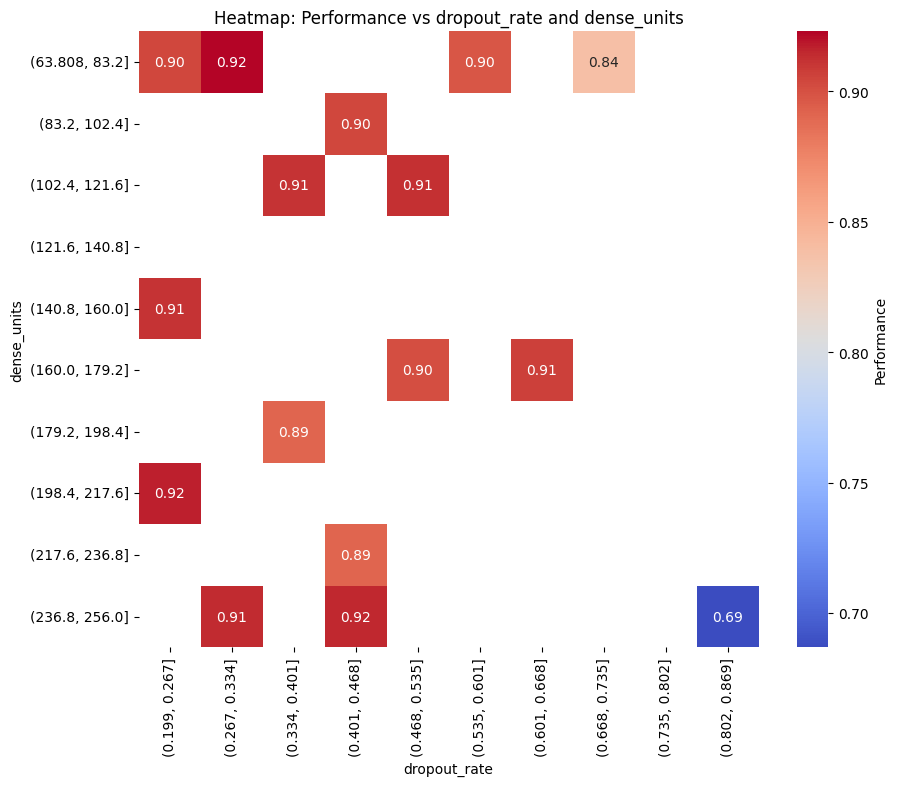

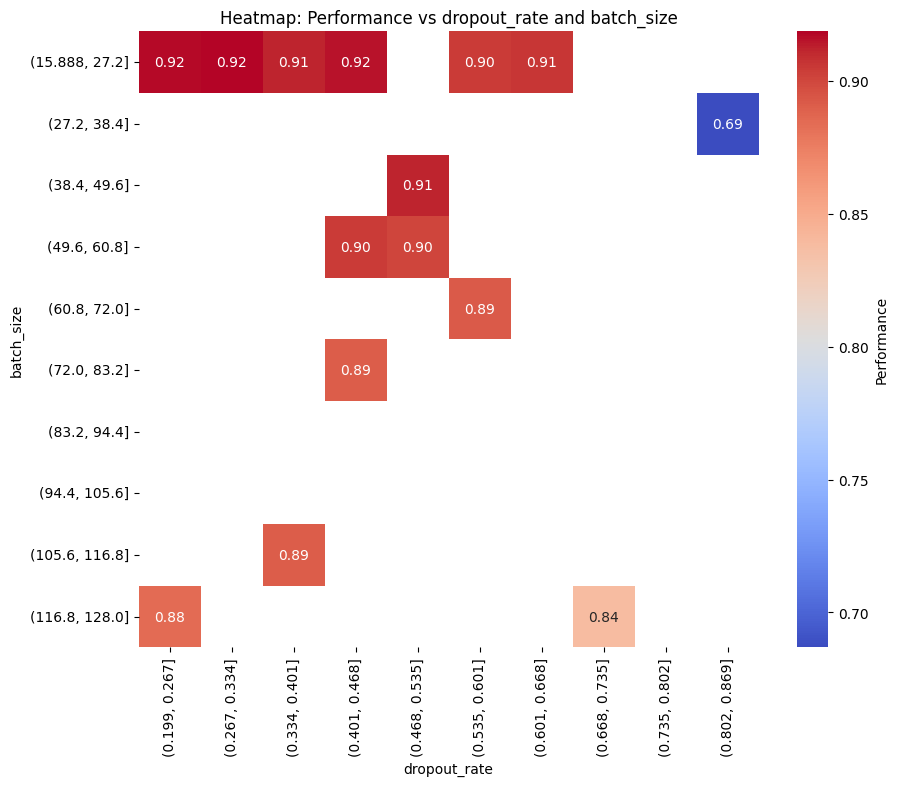

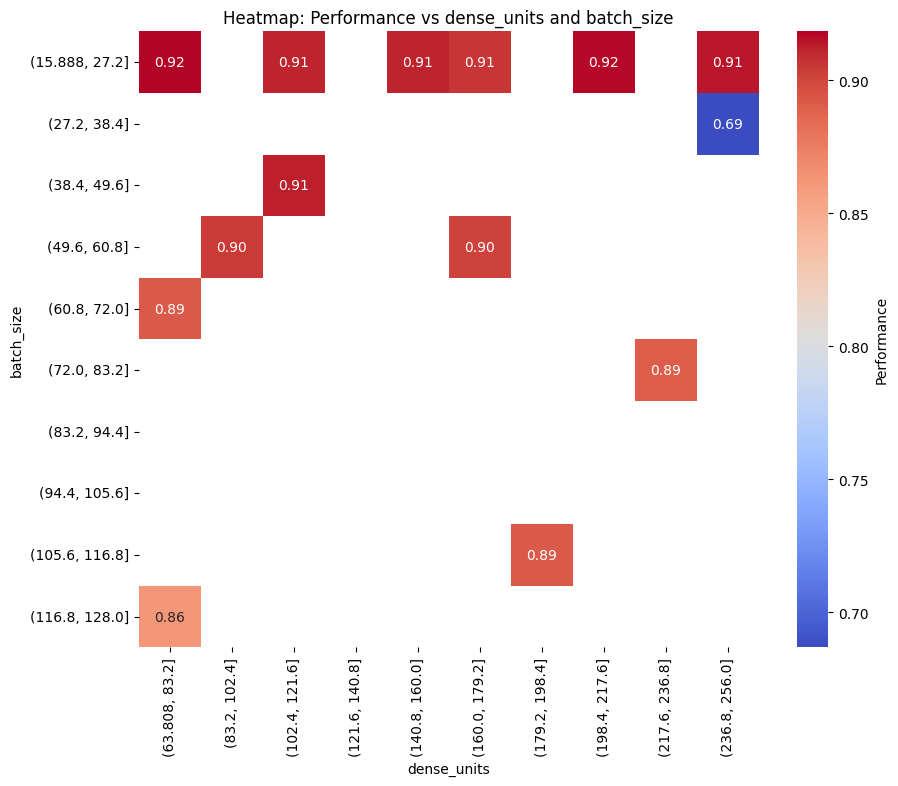

In [78]:
def plot_heatmaps(results):
    func_values = -results.func_vals
    params = results.x_iters

    param_names = ['learning_rate', 'dropout_rate', 'dense_units', 'batch_size']
    param_combinations = list(itertools.combinations(param_names, 2))

    # Create a dataframe to store the parameter values and corresponding performance
    df = pd.DataFrame(params, columns=param_names)
    df['performance'] = func_values

    for combo in param_combinations:
        param1, param2 = combo

        # Prepare data for the heatmap
        heatmap_data = df.groupby([pd.cut(df[param2], 10), pd.cut(df[param1], 10)])['performance'].mean().unstack()

        # Plot the heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'label': 'Performance'})
        plt.xlabel(param1)
        plt.ylabel(param2)
        plt.title(f"Heatmap: Performance vs {param1} and {param2}")
        plt.show()

plot_heatmaps(result)



In [79]:
if result is not None:

    print("Best parameters from Gaussian process")

    param_names = ['learning_rate', 'dropout_rate', 'dense_units', 'batch_size']
    best_parameters = result.x

    for name, value in zip(param_names, best_parameters):
        print(f"{name}: {value}")

Best parameters from Gaussian process
learning_rate: 0.009489541240873502
dropout_rate: 0.27948350463720023
dense_units: 64
batch_size: 16


In [13]:
other_params = {
    "batch_size": 32,
    "activation_function": "relu",
    "epochs": 15,
    "loss_function": "binary_crossentropy"
}

# best config was found by running the sweep algorithm below
#best_config = sweep_architecture_params(BASE_IMAGE_DIR, 5, other_params=other_params)



### Grid search for params based on fixed architecture

In [73]:
# of the candidate architectures, the second one in the list is best
# now, run a grid search to find other params

activation_functions = ['relu']
batch_sizes = [16, 32, 64]
dropout_rates = [.2, .5, .9]
loss_functions = ['binary_crossentropy']
epochs_list = [15]

# call the grid search function to evaluate the best model combination

grid_search_results = grid_search(
    BASE_IMAGE_DIR,
    best_config,
    dropout_rates,
    batch_sizes,
    loss_functions, 
    epochs_list
)



Training model: model_dropout_0.2_16_binary_crossentropy_15
Building model: model_dropout_0.2_16_binary_crossentropy_15...
Using dropout rate: 0.2
Using dropout rate: 0.2
Using dropout rate: 0.2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                           

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 73s 57ms/step - loss: 0.6136 - acc: 0.6448 - val_loss: 0.5306 - val_acc: 0.7349
Epoch 2/15
1249/1249 [==============================] - 75s 60ms/step - loss: 0.4957 - acc: 0.7579 - val_loss: 0.4494 - val_acc: 0.7873
Epoch 3/15
1249/1249 [==============================] - 73s 58ms/step - loss: 0.4241 - acc: 0.8019 - val_loss: 0.4008 - val_acc: 0.8162
Epoch 4/15
1249/1249 [==============================] - 71s 56ms/step - loss: 0.3623 - acc: 0.8393 - val_loss: 0.3469 - val_acc: 0.8422
Epoch 5/15
1249/1249 [==============================] - 73s 58ms/step - loss: 0.3160 - acc: 0.8625 - val_loss: 0.3420 - val_acc: 0.8520
Epoch 6/15
1249/1249 [==============================] - 73s 59ms/step - loss: 0.2800 - acc: 0.8789 - val_loss: 0.2850 - val_acc: 0.8781
Epoch 7/15
1249/1249 [==============================] - 78s 62ms/step - loss: 0.2446 - acc: 0.8972 - val_loss: 0.2716 - val_acc: 0.8825
Epoch 8/15
1249/1249 [==============================] - 89s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.2_16_binary_crossentropy_15\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.2_16_binary_crossentropy_15\assets


Training model: model_dropout_0.2_32_binary_crossentropy_15
Building model: model_dropout_0.2_32_binary_crossentropy_15...
Using dropout rate: 0.2
Using dropout rate: 0.2
Using dropout rate: 0.2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                           

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 48s 74ms/step - loss: 0.6171 - acc: 0.6447 - val_loss: 0.5588 - val_acc: 0.7062
Epoch 2/15
625/625 [==============================] - 46s 74ms/step - loss: 0.5325 - acc: 0.7286 - val_loss: 0.4720 - val_acc: 0.7781
Epoch 3/15
625/625 [==============================] - 45s 72ms/step - loss: 0.4558 - acc: 0.7815 - val_loss: 0.4083 - val_acc: 0.8148
Epoch 4/15
625/625 [==============================] - 41s 66ms/step - loss: 0.3932 - acc: 0.8217 - val_loss: 0.3582 - val_acc: 0.8458
Epoch 5/15
625/625 [==============================] - 44s 70ms/step - loss: 0.3372 - acc: 0.8543 - val_loss: 0.3121 - val_acc: 0.8674
Epoch 6/15
625/625 [==============================] - 42s 67ms/step - loss: 0.3008 - acc: 0.8707 - val_loss: 0.3526 - val_acc: 0.8512
Epoch 7/15
625/625 [==============================] - 49s 77ms/step - loss: 0.2732 - acc: 0.8826 - val_loss: 0.2763 - val_acc: 0.8855
Epoch 8/15
625/625 [==============================] - 41s 66ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.2_32_binary_crossentropy_15\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.2_32_binary_crossentropy_15\assets


Training model: model_dropout_0.2_64_binary_crossentropy_15
Building model: model_dropout_0.2_64_binary_crossentropy_15...
Using dropout rate: 0.2
Using dropout rate: 0.2
Using dropout rate: 0.2
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                           

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


313/313 [==============================] - 43s 132ms/step - loss: 0.6248 - acc: 0.6299 - val_loss: 0.5479 - val_acc: 0.7151
Epoch 2/15
313/313 [==============================] - 42s 134ms/step - loss: 0.5348 - acc: 0.7271 - val_loss: 0.5028 - val_acc: 0.7521
Epoch 3/15
313/313 [==============================] - 40s 128ms/step - loss: 0.4795 - acc: 0.7683 - val_loss: 0.4520 - val_acc: 0.7853
Epoch 4/15
313/313 [==============================] - 41s 130ms/step - loss: 0.4342 - acc: 0.7971 - val_loss: 0.4689 - val_acc: 0.7841
Epoch 5/15
313/313 [==============================] - 43s 136ms/step - loss: 0.3951 - acc: 0.8218 - val_loss: 0.3755 - val_acc: 0.8292
Epoch 6/15
313/313 [==============================] - 40s 128ms/step - loss: 0.3585 - acc: 0.8434 - val_loss: 0.3337 - val_acc: 0.8546
Epoch 7/15
313/313 [==============================] - 41s 131ms/step - loss: 0.3300 - acc: 0.8574 - val_loss: 0.3164 - val_acc: 0.8636
Epoch 8/15
313/313 [==============================] - 39s 125ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.2_64_binary_crossentropy_15\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.2_64_binary_crossentropy_15\assets


Training model: model_dropout_0.5_16_binary_crossentropy_15
Building model: model_dropout_0.5_16_binary_crossentropy_15...
Using dropout rate: 0.5
Using dropout rate: 0.5
Using dropout rate: 0.5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                           

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 78s 62ms/step - loss: 0.6498 - acc: 0.6089 - val_loss: 0.5741 - val_acc: 0.6984
Epoch 2/15
1249/1249 [==============================] - 74s 59ms/step - loss: 0.5680 - acc: 0.6989 - val_loss: 0.5578 - val_acc: 0.7207
Epoch 3/15
1249/1249 [==============================] - 74s 59ms/step - loss: 0.5244 - acc: 0.7368 - val_loss: 0.4975 - val_acc: 0.7515
Epoch 4/15
1249/1249 [==============================] - 71s 57ms/step - loss: 0.4849 - acc: 0.7613 - val_loss: 0.4717 - val_acc: 0.7775
Epoch 5/15
1249/1249 [==============================] - 73s 59ms/step - loss: 0.4421 - acc: 0.7916 - val_loss: 0.4474 - val_acc: 0.7909
Epoch 6/15
1249/1249 [==============================] - 74s 59ms/step - loss: 0.3907 - acc: 0.8222 - val_loss: 0.4056 - val_acc: 0.8216
Epoch 7/15
1249/1249 [==============================] - 74s 59ms/step - loss: 0.3555 - acc: 0.8416 - val_loss: 0.3295 - val_acc: 0.8574
Epoch 8/15
1249/1249 [==============================] - 72s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.5_16_binary_crossentropy_15\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.5_16_binary_crossentropy_15\assets


Training model: model_dropout_0.5_32_binary_crossentropy_15
Building model: model_dropout_0.5_32_binary_crossentropy_15...
Using dropout rate: 0.5
Using dropout rate: 0.5
Using dropout rate: 0.5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                           

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 40s 62ms/step - loss: 0.6743 - acc: 0.5684 - val_loss: 0.6275 - val_acc: 0.6280
Epoch 2/15
625/625 [==============================] - 41s 65ms/step - loss: 0.5780 - acc: 0.6904 - val_loss: 0.5389 - val_acc: 0.7235
Epoch 3/15
625/625 [==============================] - 46s 73ms/step - loss: 0.5133 - acc: 0.7431 - val_loss: 0.5359 - val_acc: 0.7335
Epoch 4/15
625/625 [==============================] - 40s 63ms/step - loss: 0.4618 - acc: 0.7773 - val_loss: 0.4383 - val_acc: 0.7966
Epoch 5/15
625/625 [==============================] - 43s 68ms/step - loss: 0.4129 - acc: 0.8103 - val_loss: 0.4167 - val_acc: 0.8088
Epoch 6/15
625/625 [==============================] - 42s 68ms/step - loss: 0.3809 - acc: 0.8263 - val_loss: 0.3720 - val_acc: 0.8380
Epoch 7/15
625/625 [==============================] - 43s 68ms/step - loss: 0.3492 - acc: 0.8484 - val_loss: 0.3484 - val_acc: 0.8440
Epoch 8/15
625/625 [==============================] - 40s 63ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.5_32_binary_crossentropy_15\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.5_32_binary_crossentropy_15\assets


Training model: model_dropout_0.5_64_binary_crossentropy_15
Building model: model_dropout_0.5_64_binary_crossentropy_15...
Using dropout rate: 0.5
Using dropout rate: 0.5
Using dropout rate: 0.5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                           

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


313/313 [==============================] - 44s 136ms/step - loss: 0.6610 - acc: 0.5856 - val_loss: 0.6112 - val_acc: 0.6496
Epoch 2/15
313/313 [==============================] - 45s 139ms/step - loss: 0.5827 - acc: 0.6790 - val_loss: 0.5414 - val_acc: 0.7235
Epoch 3/15
313/313 [==============================] - 40s 128ms/step - loss: 0.5357 - acc: 0.7255 - val_loss: 0.5143 - val_acc: 0.7429
Epoch 4/15
313/313 [==============================] - 44s 138ms/step - loss: 0.5015 - acc: 0.7468 - val_loss: 0.4929 - val_acc: 0.7607
Epoch 5/15
313/313 [==============================] - 40s 127ms/step - loss: 0.4493 - acc: 0.7867 - val_loss: 0.4537 - val_acc: 0.7905
Epoch 6/15
313/313 [==============================] - 42s 133ms/step - loss: 0.4123 - acc: 0.8124 - val_loss: 0.3854 - val_acc: 0.8228
Epoch 7/15
313/313 [==============================] - 39s 124ms/step - loss: 0.3736 - acc: 0.8317 - val_loss: 0.3764 - val_acc: 0.8250
Epoch 8/15
313/313 [==============================] - 41s 129ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.5_64_binary_crossentropy_15\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.5_64_binary_crossentropy_15\assets


Training model: model_dropout_0.9_16_binary_crossentropy_15
Building model: model_dropout_0.9_16_binary_crossentropy_15...
Using dropout rate: 0.9
Using dropout rate: 0.9
Using dropout rate: 0.9
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                           

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 74s 59ms/step - loss: 0.6851 - acc: 0.5510 - val_loss: 0.7673 - val_acc: 0.5000
Epoch 2/15
1249/1249 [==============================] - 71s 57ms/step - loss: 0.6302 - acc: 0.6360 - val_loss: 0.8831 - val_acc: 0.5192
Epoch 3/15
1249/1249 [==============================] - 72s 57ms/step - loss: 0.5881 - acc: 0.6865 - val_loss: 1.0631 - val_acc: 0.5114
Epoch 4/15
1249/1249 [==============================] - 74s 59ms/step - loss: 0.5655 - acc: 0.7091 - val_loss: 1.1191 - val_acc: 0.5072
Epoch 5/15
1249/1249 [==============================] - 74s 59ms/step - loss: 0.5537 - acc: 0.7178 - val_loss: 1.0604 - val_acc: 0.5138
Epoch 6/15
1249/1249 [==============================] - 73s 59ms/step - loss: 0.5392 - acc: 0.7285 - val_loss: 1.1230 - val_acc: 0.5086
Epoch 7/15
1249/1249 [==============================] - 73s 58ms/step - loss: 0.5230 - acc: 0.7422 - val_loss: 1.2725 - val_acc: 0.5068
Epoch 8/15
1249/1249 [==============================] - 73s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.9_16_binary_crossentropy_15\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.9_16_binary_crossentropy_15\assets


Training model: model_dropout_0.9_32_binary_crossentropy_15
Building model: model_dropout_0.9_32_binary_crossentropy_15...
Using dropout rate: 0.9
Using dropout rate: 0.9
Using dropout rate: 0.9
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                           

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 48s 75ms/step - loss: 0.6599 - acc: 0.5882 - val_loss: 0.8138 - val_acc: 0.5028
Epoch 2/15
625/625 [==============================] - 43s 69ms/step - loss: 0.5955 - acc: 0.6773 - val_loss: 1.0425 - val_acc: 0.5072
Epoch 3/15
625/625 [==============================] - 40s 63ms/step - loss: 0.5664 - acc: 0.7096 - val_loss: 1.1148 - val_acc: 0.5162
Epoch 4/15
625/625 [==============================] - 39s 63ms/step - loss: 0.5507 - acc: 0.7217 - val_loss: 1.1389 - val_acc: 0.5182
Epoch 5/15
625/625 [==============================] - 42s 67ms/step - loss: 0.5378 - acc: 0.7333 - val_loss: 1.2195 - val_acc: 0.5166
Epoch 6/15
625/625 [==============================] - 42s 67ms/step - loss: 0.5274 - acc: 0.7382 - val_loss: 1.2954 - val_acc: 0.5126
Epoch 7/15
625/625 [==============================] - 43s 68ms/step - loss: 0.5122 - acc: 0.7508 - val_loss: 1.4046 - val_acc: 0.5044
Epoch 8/15
625/625 [==============================] - 42s 67ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.9_32_binary_crossentropy_15\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.9_32_binary_crossentropy_15\assets


Training model: model_dropout_0.9_64_binary_crossentropy_15
Building model: model_dropout_0.9_64_binary_crossentropy_15...
Using dropout rate: 0.9
Using dropout rate: 0.9
Using dropout rate: 0.9
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                           

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


313/313 [==============================] - 44s 136ms/step - loss: 0.6825 - acc: 0.5534 - val_loss: 0.7432 - val_acc: 0.5000
Epoch 2/15
313/313 [==============================] - 39s 124ms/step - loss: 0.6339 - acc: 0.6303 - val_loss: 0.7938 - val_acc: 0.5062
Epoch 3/15
313/313 [==============================] - 41s 131ms/step - loss: 0.5966 - acc: 0.6746 - val_loss: 0.9339 - val_acc: 0.5118
Epoch 4/15
313/313 [==============================] - 42s 133ms/step - loss: 0.5682 - acc: 0.7067 - val_loss: 1.0776 - val_acc: 0.5108
Epoch 5/15
313/313 [==============================] - 42s 128ms/step - loss: 0.5452 - acc: 0.7254 - val_loss: 1.0911 - val_acc: 0.5190
Epoch 6/15
313/313 [==============================] - 43s 135ms/step - loss: 0.5311 - acc: 0.7362 - val_loss: 1.2723 - val_acc: 0.5084
Epoch 7/15
313/313 [==============================] - 43s 137ms/step - loss: 0.5154 - acc: 0.7518 - val_loss: 1.5276 - val_acc: 0.5006
Epoch 8/15
313/313 [==============================] - 41s 130ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.9_64_binary_crossentropy_15\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_dropout_0.9_64_binary_crossentropy_15\assets


Model: model_dropout_0.2_16_binary_crossentropy_15, best validation accuracy: 0.9187024235725403


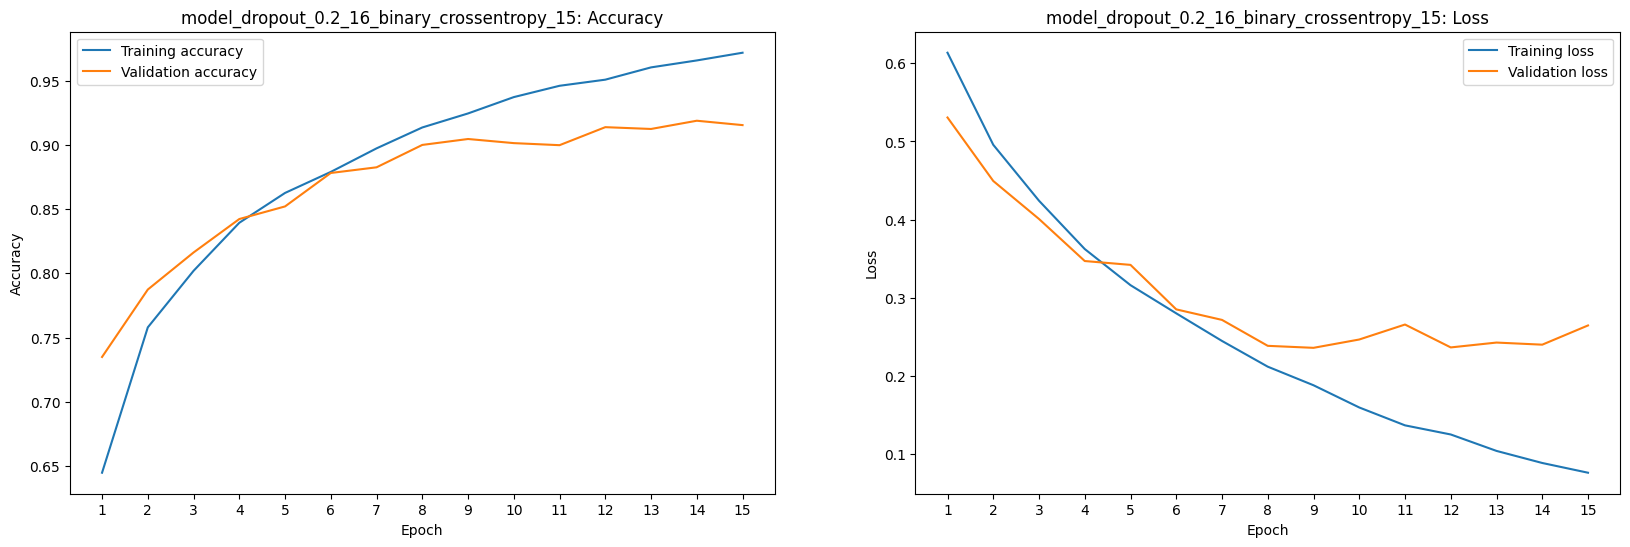

Model: model_dropout_0.2_32_binary_crossentropy_15, best validation accuracy: 0.920504629611969


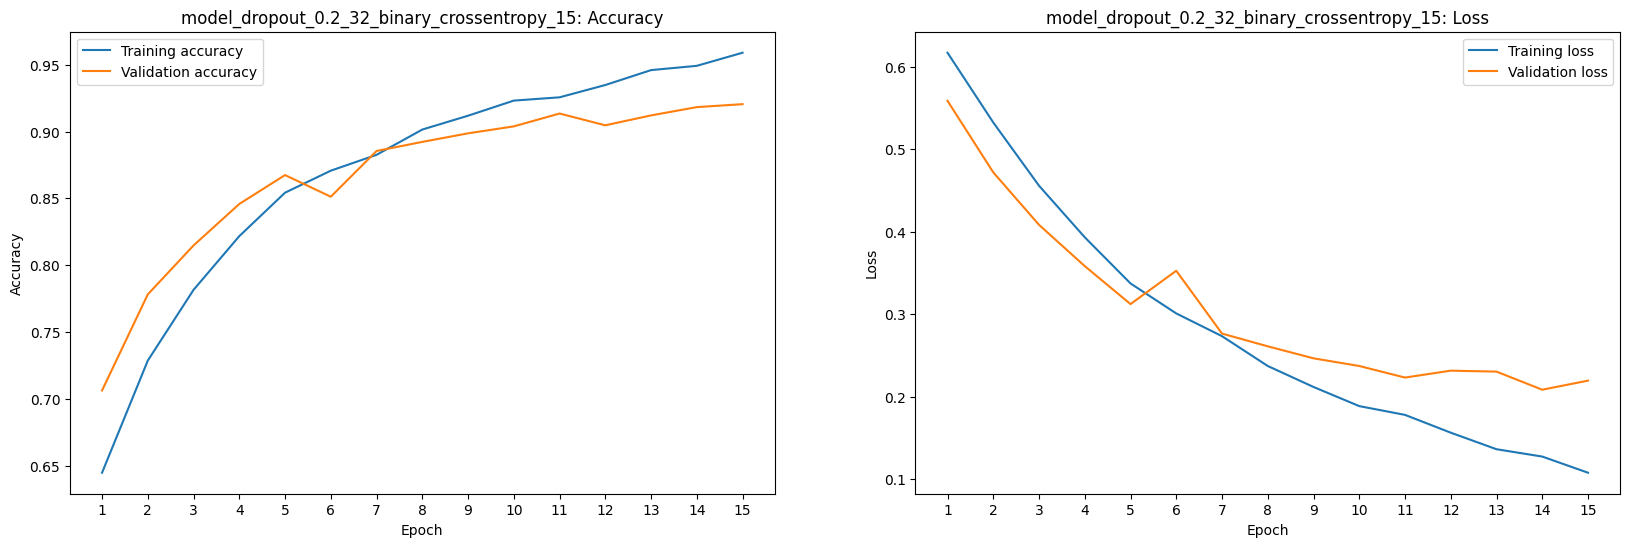

Model: model_dropout_0.2_64_binary_crossentropy_15, best validation accuracy: 0.8984781503677368


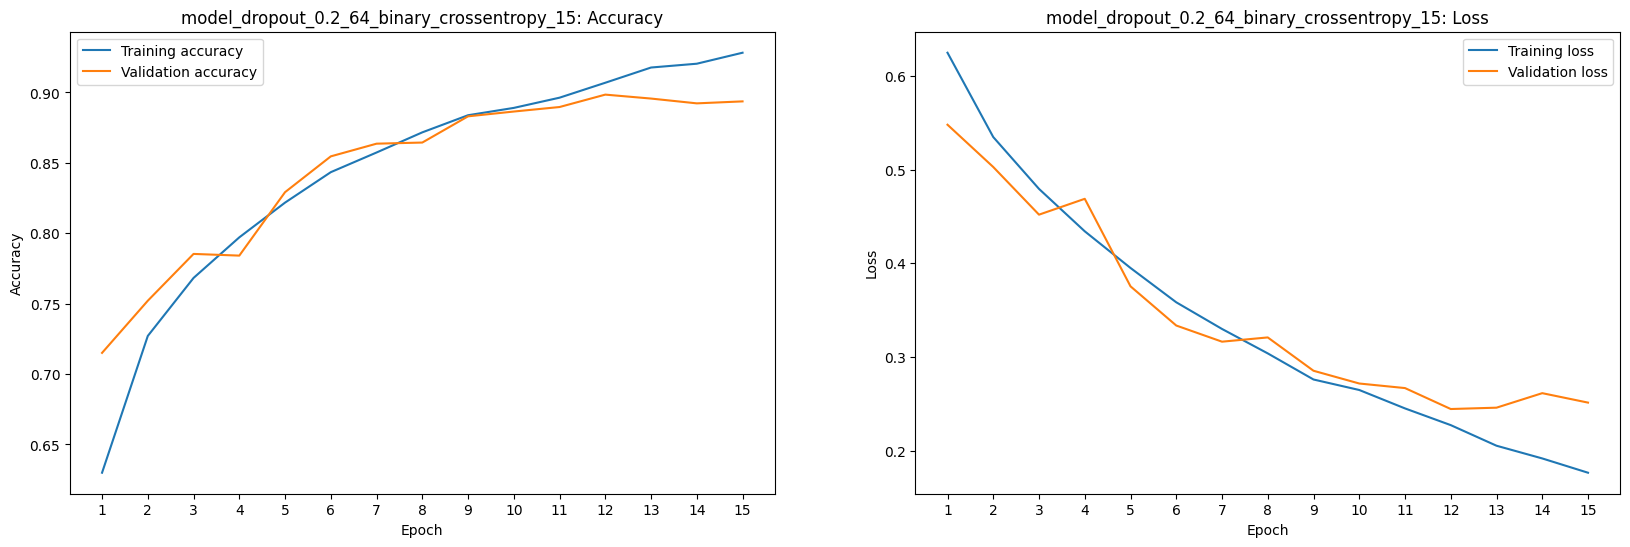

Model: model_dropout_0.5_16_binary_crossentropy_15, best validation accuracy: 0.9006808400154114


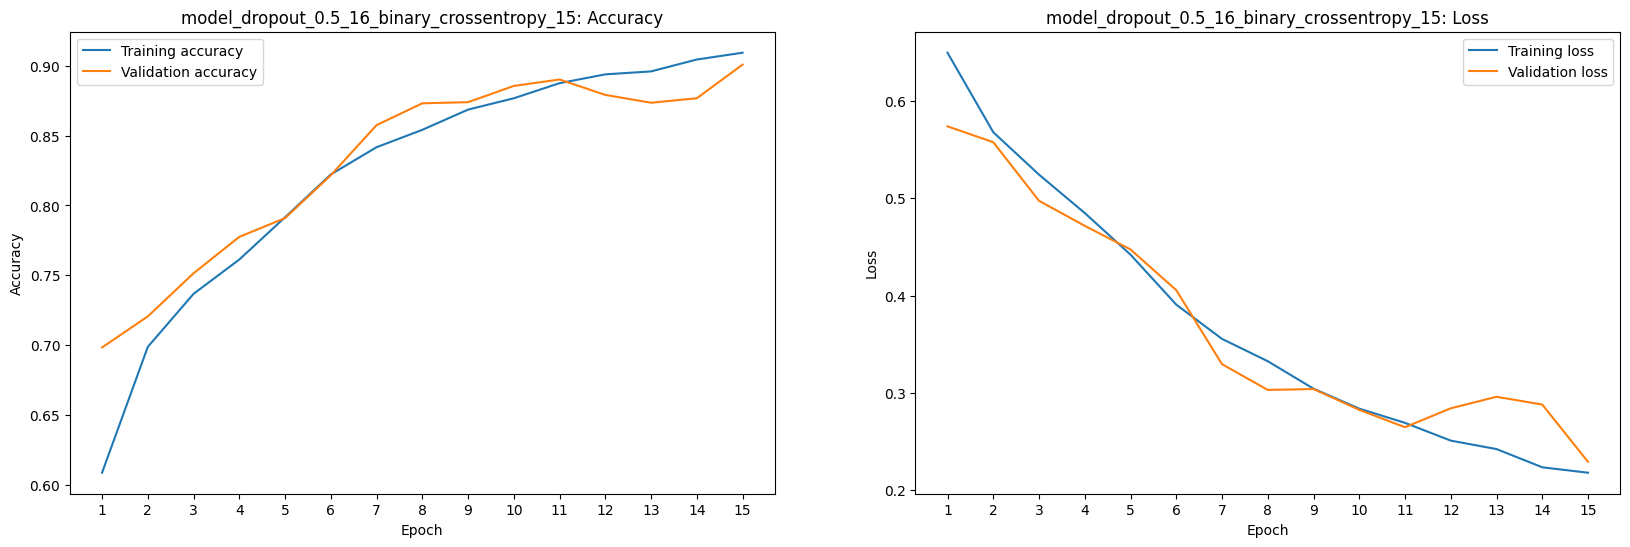

Model: model_dropout_0.5_32_binary_crossentropy_15, best validation accuracy: 0.9002803564071655


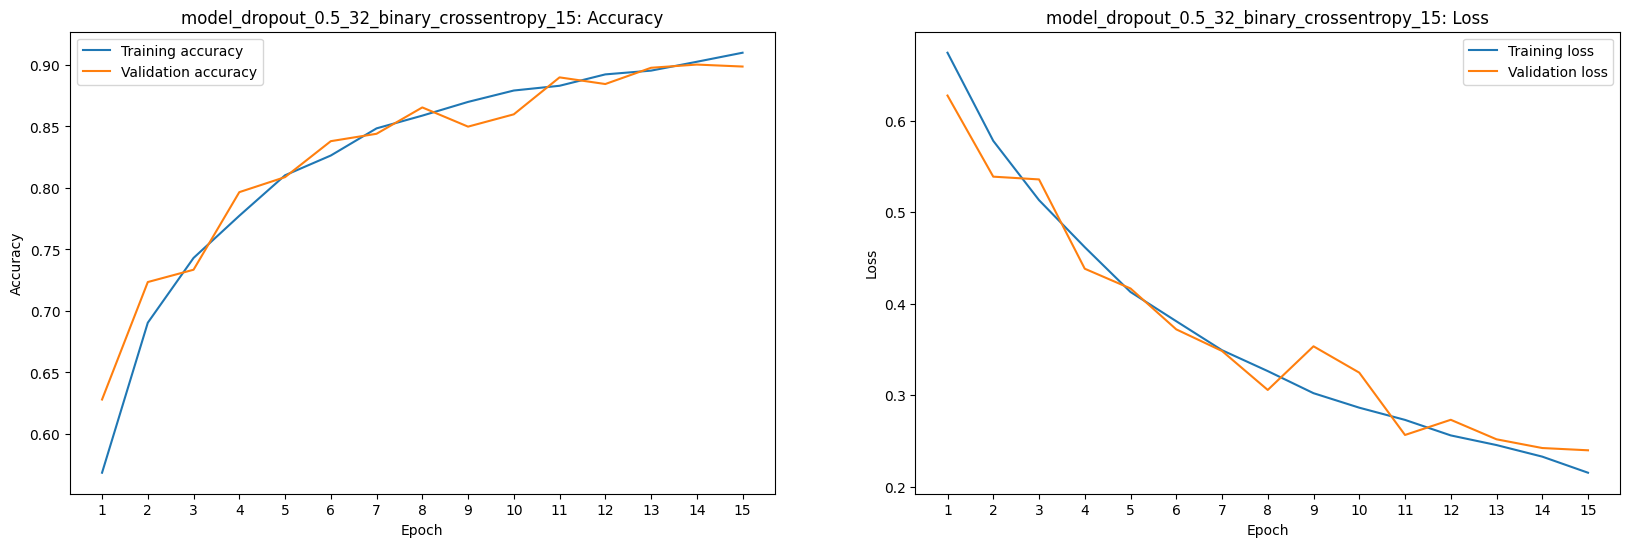

Model: model_dropout_0.5_64_binary_crossentropy_15, best validation accuracy: 0.9034841656684875


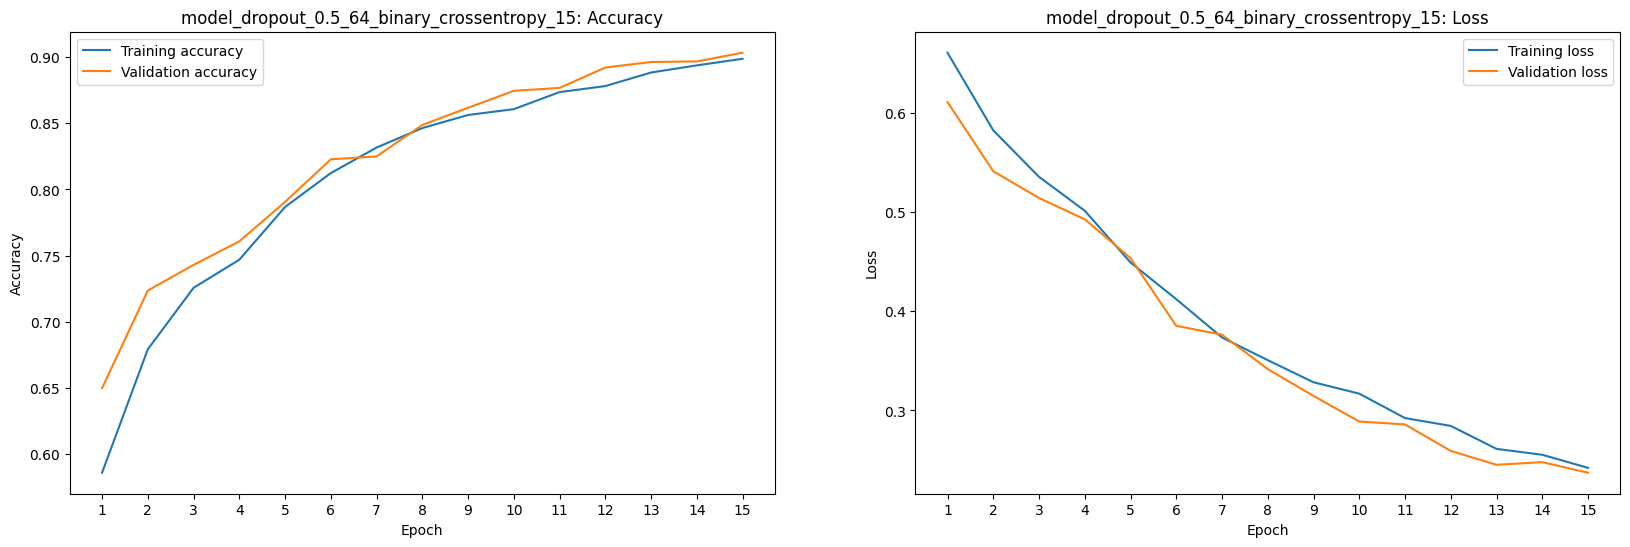

Model: model_dropout_0.9_16_binary_crossentropy_15, best validation accuracy: 0.523227870464325


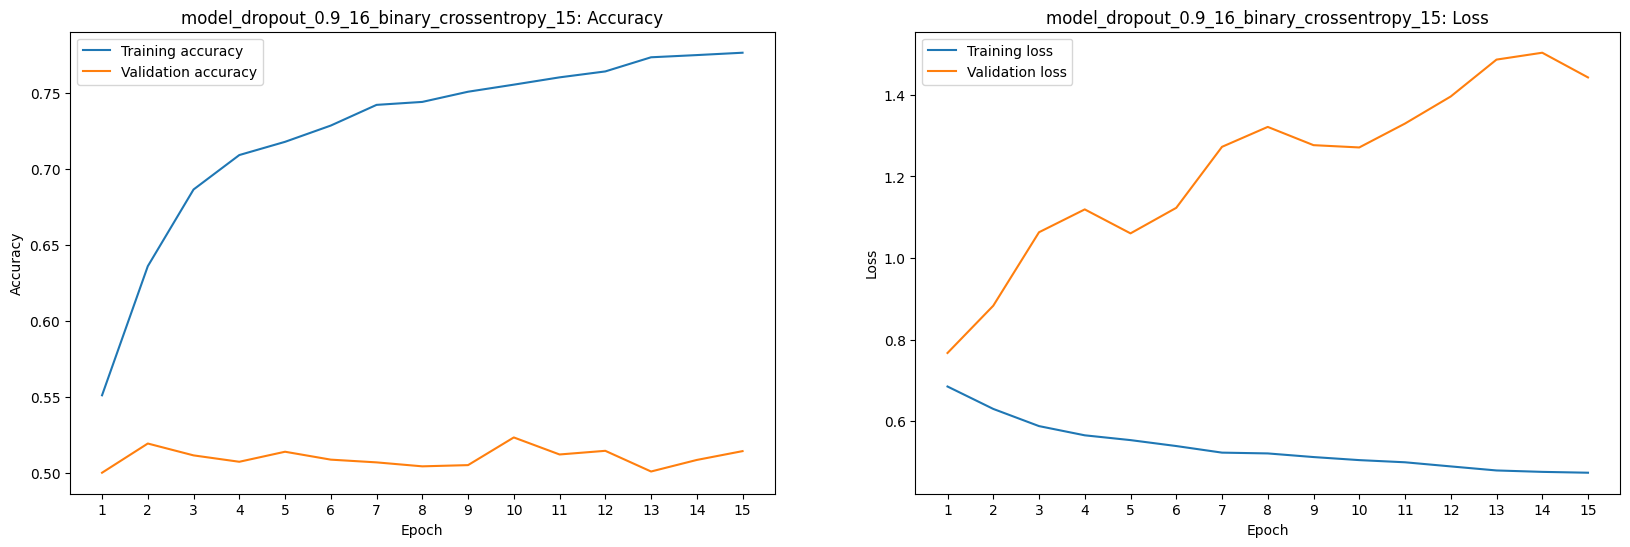

Model: model_dropout_0.9_32_binary_crossentropy_15, best validation accuracy: 0.5182218551635742


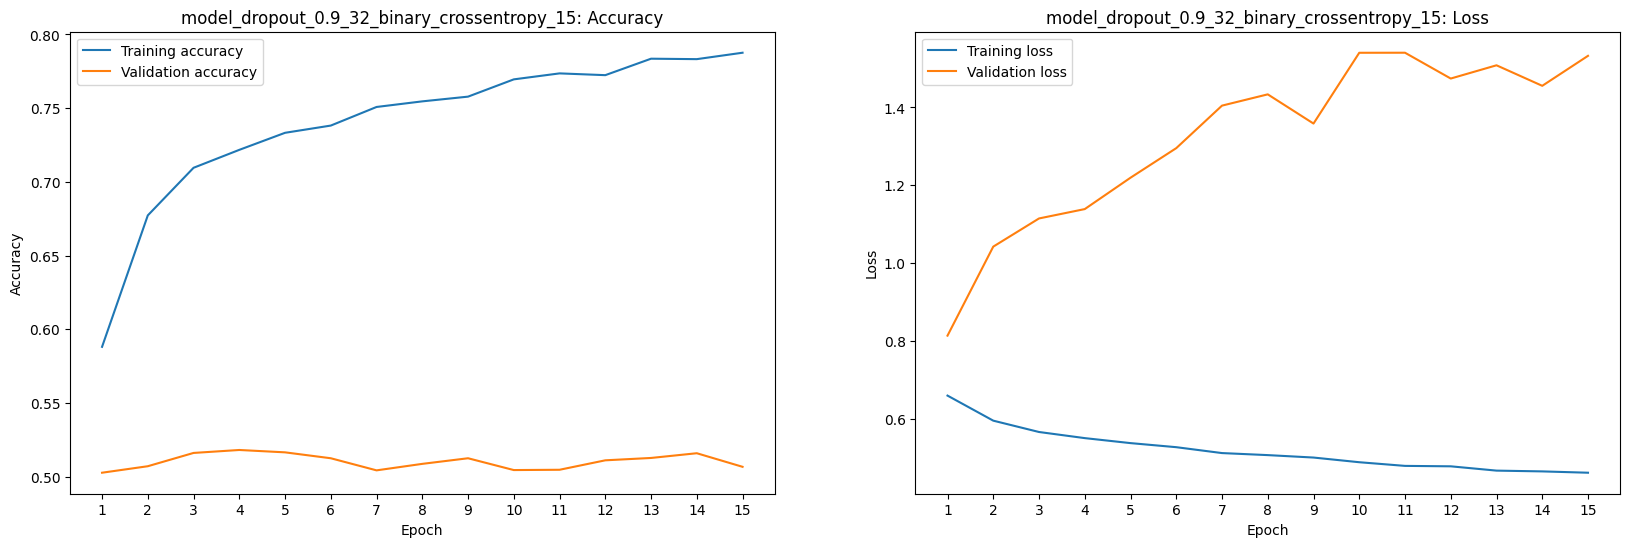

Model: model_dropout_0.9_64_binary_crossentropy_15, best validation accuracy: 0.5190228223800659


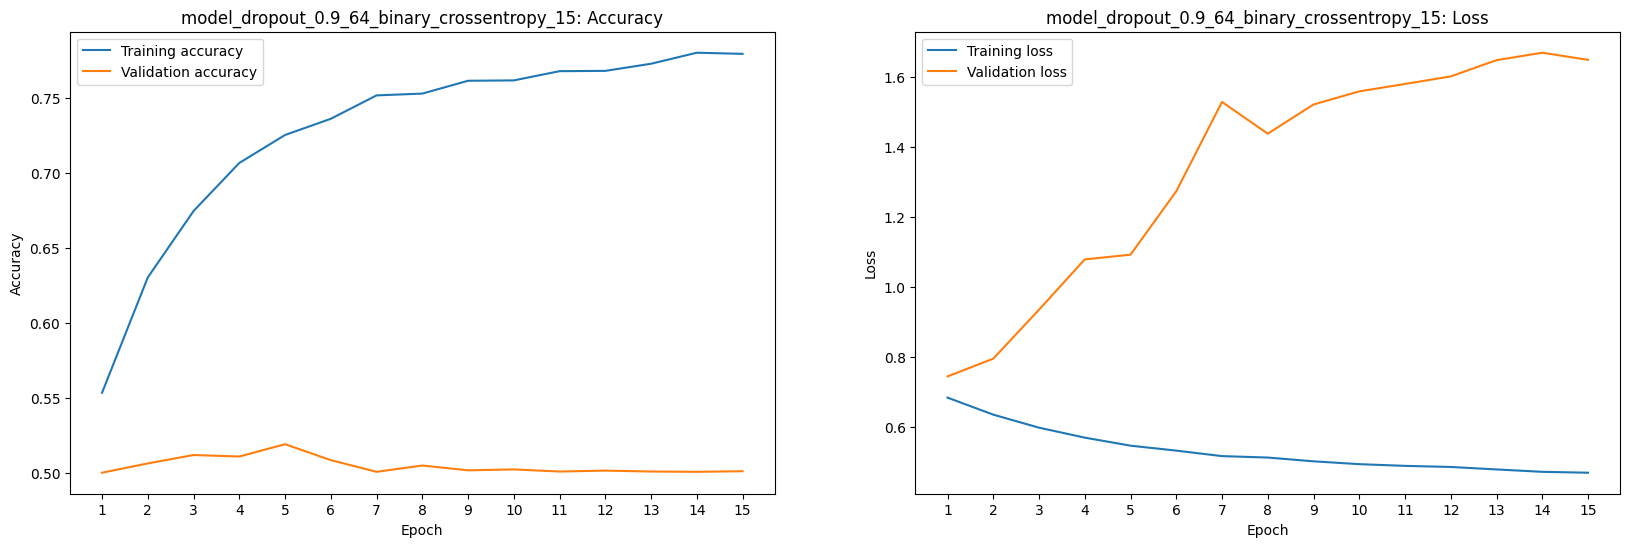

In [76]:
# best is: model_relu_64_binary_crossentropy_30

def plot_results_grid(results, save_dir='C:/dev/programming_2023/cnn_project/training_plots'):

    for i, result in enumerate(results):
        model_name = result['model_name']
        accuracy = result['accuracy']
        validation_accuracy = result['validation_accuracy']
        loss = result['loss']
        validation_loss = result['validation_loss']
        epochs = range(1, len(accuracy) + 1)
        
        print("Model: {}, best validation accuracy: {}".format(model_name, max(validation_accuracy)))

        fig, axes = plt.subplots(1, 2, figsize=(20, 6))

        # Plot accuracy
        axes[0].set_title(f"{model_name}: Accuracy")
        axes[0].plot(epochs, accuracy, label='Training accuracy')
        axes[0].plot(epochs, validation_accuracy, label='Validation accuracy')
        axes[0].set_xlabel("Epoch")
        axes[0].set_xticks(epochs)
        axes[0].set_ylabel("Accuracy")
        axes[0].legend()

        # Plot loss
        axes[1].set_title(f"{model_name}: Loss")
        axes[1].plot(epochs, loss, label='Training loss')
        axes[1].plot(epochs, validation_loss, label='Validation loss')
        axes[1].set_xlabel("Epoch")
        axes[1].set_xticks(epochs)
        axes[1].set_ylabel("Loss")
        axes[1].legend()

        # Save the figure
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.show()
        fig.savefig(os.path.join(save_dir, f"{model_name}.png"))
        plt.close(fig)  # Close the figure to save memory

# Call the function with the results list
plot_results_grid(grid_search_results)


In [66]:
# run model with best hyperparamters for 50 epochs
epochs = 100

learning_rate = best_parameters[0]
dropout_rate = best_parameters[1]
dense_units = best_parameters[2]
batch_size = best_parameters[3]

best_classifier_ = CatDogImageClassifier(
    model_name="Gaussian process hyperparameters",
    batch_size=batch_size,
    activation_function='relu',
    loss_function='binary_crossentropy',
    epochs=epochs,
    layer_configs=best_config,
    dropout_rate=dropout_rate
)

best_classifier_.build()
best_classifier_.train(BASE_IMAGE_DIR)


Building model: Gaussian process hyperparameters...
Using dropout rate: 0.5
Using dropout rate: 0.5
Using dropout rate: 0.5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85, 64)        51264     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 42, 42, 64)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 42, 42, 64)        0        

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1176/1176 [==============================] - 51s 43ms/step - loss: 0.6256 - acc: 0.6350 - val_loss: 0.5553 - val_acc: 0.7064
Epoch 2/100
1176/1176 [==============================] - 45s 38ms/step - loss: 0.5262 - acc: 0.7329 - val_loss: 0.4759 - val_acc: 0.7725
Epoch 3/100
1176/1176 [==============================] - 47s 40ms/step - loss: 0.4541 - acc: 0.7858 - val_loss: 0.4220 - val_acc: 0.8050
Epoch 4/100
1176/1176 [==============================] - 50s 43ms/step - loss: 0.4063 - acc: 0.8151 - val_loss: 0.3839 - val_acc: 0.8258
Epoch 5/100
1176/1176 [==============================] - 45s 38ms/step - loss: 0.3672 - acc: 0.8367 - val_loss: 0.3955 - val_acc: 0.8194
Epoch 6/100
1176/1176 [==============================] - 48s 41ms/step - loss: 0.3311 - acc: 0.8556 - val_loss: 0.3146 - val_acc: 0.8682
Epoch 7/100
1176/1176 [==============================] - 44s 37ms/step - loss: 0.2983 - acc: 0.8702 - val_loss: 0.2999 - val_acc: 0.8692
Epoch 8/100
1176/1176 [==============================

1176/1176 [==============================] - 43s 37ms/step - loss: 0.0401 - acc: 0.9848 - val_loss: 0.2221 - val_acc: 0.9373
Epoch 61/100
1176/1176 [==============================] - 46s 39ms/step - loss: 0.0412 - acc: 0.9856 - val_loss: 0.2182 - val_acc: 0.9371
Epoch 62/100
1176/1176 [==============================] - 46s 38ms/step - loss: 0.0435 - acc: 0.9841 - val_loss: 0.2215 - val_acc: 0.9335
Epoch 63/100
1176/1176 [==============================] - 47s 40ms/step - loss: 0.0419 - acc: 0.9842 - val_loss: 0.2021 - val_acc: 0.9369
Epoch 64/100
1176/1176 [==============================] - 46s 39ms/step - loss: 0.0402 - acc: 0.9851 - val_loss: 0.2022 - val_acc: 0.9367
Epoch 65/100
1176/1176 [==============================] - 46s 39ms/step - loss: 0.0416 - acc: 0.9848 - val_loss: 0.2157 - val_acc: 0.9375
Epoch 66/100
1176/1176 [==============================] - 46s 39ms/step - loss: 0.0402 - acc: 0.9857 - val_loss: 0.2456 - val_acc: 0.9319
Epoch 67/100
1176/1176 [=======================

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/Gaussian process hyperparameters\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/Gaussian process hyperparameters\assets


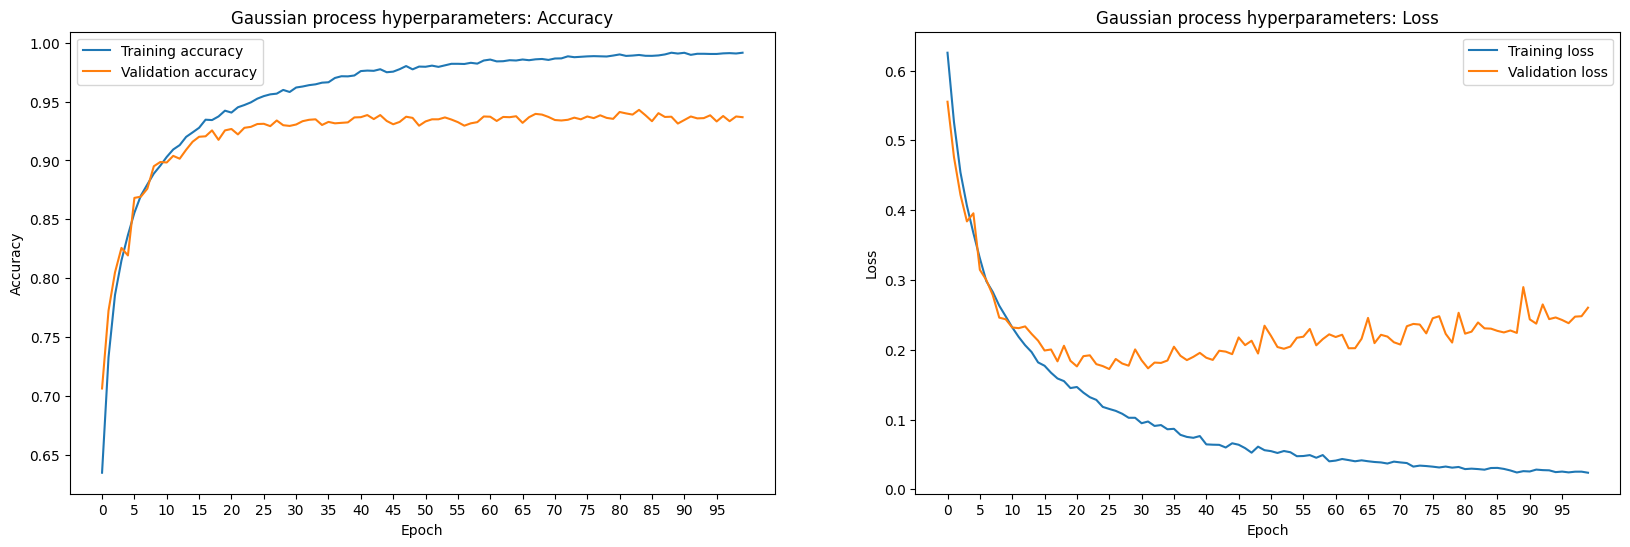

0.9453343749046326


In [67]:
best_classifier_.plot_results(save_dir=SAVE_DIR)
print(max(best_classifier.validation_acc))

# Appendix

In [ ]:
# LEGACY hardcodes candidate configs (pre random search)
candidate_architecture_configs = [
    # 2 convolutional layers, single dense layer
    [
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 48, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
    # 3 convolutional layers, 2 dense layers (prev best)
    [
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 48, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 128, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 64, "activation": "relu"},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
    # single conolutional layer, single dense layer
    [
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 64, "activation": "relu"},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
    [
        # 3 convolutional layers, single dense layer
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 48, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 96, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
]


## Data Augmentation??

In [ ]:
TEST_CAT_DIR = r'C:\dev\programming_2023\cnn_project\test_cat'
        
first_images = os.listdir(TEST_CAT_DIR)[:20]
for image in first_images:
    test_img_path = "{}/{}".format(TEST_CAT_DIR, image)
    
    test_img =  cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
    
    # resize to  the net's inputs, normalize, and expant dims (for batch tensor)
    test_img = cv2.resize(test_img, (256, 256), interpolation=cv2.INTER_LINEAR)
    test_img = test_img.astype('float32') / 255.0
    test_img_expanded = np.expand_dims(test_img, axis=0)
    
    print(np.shape(test_img_expanded))
    break

    class_probabilities = model.predict(test_img_expanded)
    
    plt.imshow(test_img)
    plt.show()
    


In [ ]:
TEST_DOG_DIR = r'C:\dev\programming_2023\cnn_project\test_dog'
        
first_images = os.listdir(TEST_DOG_DIR)
for image in first_images:
    test_img_path = "{}/{}".format(TEST_DOG_DIR, image)
    
    test_img =  cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
    
    # resize to  the net's inputs, normalize, and expant dims (for batch tensor)
    test_img = cv2.resize(test_img, (256, 256), interpolation=cv2.INTER_LINEAR)
    test_img = test_img.astype('float32') / 255.0
    test_img_expanded = np.expand_dims(test_img, axis=0)
    
    print(np.shape(test_img_expanded))

    class_probabilities = model.predict(test_img_expanded)
    print("cat: {} dog: {}".format(class_probabilities[0][0], class_probabilities[0][1]))
    
    plt.imshow(test_img)
    plt.show()